In [217]:
# IMPORT YOUR LIBRARIES HERE
import random

import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import prettytable as pt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  LogisticRegressionCV, Ridge, RidgeCV)
from sklearn.metrics import (confusion_matrix, f1_score, mean_absolute_error,
                             mean_squared_error, precision_score, r2_score,
                             recall_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, StandardScaler)
from sklearn.tree import plot_tree

In [426]:
# Ignoring future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Assignment 1

Welcome to the assignment!

You will have to implement regression and classification algorithms, applying these methods to the topics of agriculture, food, water, and health. More precisely, you will try to:

- predict crop yields using data on weather and fertilizer use;
- predict the potability of water using data on the mineral and micro-organisms content of water.

Once you are done you have to submit your notebook here:
[https://moodle.epfl.ch/mod/assign/view.php?id=1244180](https://moodle.epfl.ch/mod/assign/view.php?id=1244180)

If there is need for further clarifications on the questions, after the assignment is released, we will update this file, so make sure you check the git repository for updates.

Good luck!


## Linear regression: predicting crop yields

In 2020, between 720 million and 811 million persons worldwide were suffering from hunger (see [SDG Goal 2](https://www.un.org/sustainabledevelopment/hunger/) Zero Hunger). Given the ongoing growth of the world population, it is imperative to comprehend crop yield at a global level in order to tackle food security issues and mitigate the effects of climate change.

The Agricultural yield depends on weather conditions (rain, temperature, etc) and fertilizers use. Having precise information regarding the historical crop yield is critical for making informed decisions regarding agricultural risk management and future projections.

Some E4S publications on the topic of food:

- [Threats to Nitrogen Fertilizer, Opportunities to Cultivate Sustainable Practices?](https://e4s.center/resources/reports/threats-to-nitrogen-fertilizer-opportunities-to-cultivate-sustainable-practices/)
- [True cost of food as a lever to transform the Swiss food system](https://e4s.center/resources/reports/true-cost-of-food-as-a-lever-to-transform-the-swiss-food-system/)

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/Sustainable_Development_Goal_02ZeroHunger.svg/800px-Sustainable_Development_Goal_02ZeroHunger.svg.png' width='200'>

We will use data obtained from the [FAO](http://www.fao.org/home/en/) (Food and Agriculture Organization) and [World Data Bank](https://data.worldbank.org/), and gathered in the [Crop Yield Prediction Dataset](https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset).

Our goal is to predict the crop yields using the temperature, rain fall, and type of crops.


### Question 1: Load and Discover the dataset


- Load the data in a dataframe. The url link is provided below. Display the first 10 observations and the types of data **1 point**


In [3]:
url_yield = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/yield_df.csv'

# local_path = '../data/yield_df.csv'
yield_df = pd.read_csv(url_yield)

I will start by renaming the columns for improved readability.

In [4]:
yield_df = yield_df.rename(index=str, columns={'year': 'Year', 'hg/ha_yield': 'Yield', 'avg_temp': 'Temperature',
                           'pesticides_tonnes': 'Pesticides', 'average_rain_fall_mm_per_year': 'Avg. Rain fall'})
display(yield_df.head(10))
display(yield_df.dtypes)


Area         Item  Year  Yield  Avg. Rain fall  Pesticides  Temperature
0  Albania        Maize  1990  36613            1485       121.0        16.37
1  Albania     Potatoes  1990  66667            1485       121.0        16.37
2  Albania  Rice, paddy  1990  23333            1485       121.0        16.37
3  Albania      Sorghum  1990  12500            1485       121.0        16.37
4  Albania     Soybeans  1990   7000            1485       121.0        16.37
5  Albania        Wheat  1990  30197            1485       121.0        16.37
6  Albania        Maize  1991  29068            1485       121.0        15.36
7  Albania     Potatoes  1991  77818            1485       121.0        15.36
8  Albania  Rice, paddy  1991  28538            1485       121.0        15.36
9  Albania      Sorghum  1991   6667            1485       121.0        15.36

Area               object
Item               object
Year                int64
Yield               int64
Avg. Rain fall      int64
Pesticides        float64
Temperature       float64
dtype: object

- Print the list of countries ('Area') and years available in the dataset **1 point**


In [5]:
# Function that returns all the unique (if set) items in the given column

def get_col_items_as_list(df, col_name, unique) -> list:
    '''
    Function that returns all the columns names in a list of a given df
    The parameter unique is used to check for unique items in the column
    '''
    if unique:
        return df[col_name].unique().tolist()
    else:
        return df[col_name].value.tolist()


In [7]:
countries = get_col_items_as_list(yield_df, 'Area', True)
years = get_col_items_as_list(yield_df, 'Year', True)

print(f'The countries in the the dataframe are:\n {countries}')
print(f'The years available in the the dataframe are:\n {years}')


The countries in the the dataframe are:
 ['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Central African Republic', 'Chile', 'Colombia', 'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Estonia', 'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Libya', 'Lithuania', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Norway', 'Pakistan', 'Papua New Guinea', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 'Saudi Arabia', 

- Print the list of 'Item' in the dataset. You should obtain a list of 10 crops, which are among the most consumed in the world **1 point**


In [8]:
items = get_col_items_as_list(yield_df, 'Item', True)
print(
    f'The most consumed crops are: \n{items}\nAnd the number of crops are: {len(items)}')


The most consumed crops are: 
['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat', 'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams']
And the number of crops are: 10


- Display summary statistics for the columns: 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes','avg_temp'. How many observations do we have? **1 point**

_Hint:_ You can extract the columns 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes','avg_temp' in a new dataframe since we will reuse it in the following questions


In [9]:
# Function to create a copy of a df with the given columns

def get_df_subset(df, cols) -> pd.DataFrame:
    return df[cols].copy()


In [417]:
columns_to_extract = [
    'Yield', 'Avg. Rain fall', 'Pesticides', 'Temperature']
yield_subset = get_df_subset(yield_df, columns_to_extract)
display(yield_subset.describe())
print(
    f'We have {yield_subset.shape[0]} observations in our new subset dataframe')


Yield  Avg. Rain fall     Pesticides   Temperature
count   28242.000000     28242.00000   28242.000000  28242.000000
mean    77053.332094      1149.05598   37076.909344     20.542627
std     84956.612897       709.81215   59958.784665      6.312051
min        50.000000        51.00000       0.040000      1.300000
25%     19919.250000       593.00000    1702.000000     16.702500
50%     38295.000000      1083.00000   17529.440000     21.510000
75%    104676.750000      1668.00000   48687.880000     26.000000
max    501412.000000      3240.00000  367778.000000     30.650000

<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28241
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Yield           28242 non-null  int64  
 1   Avg. Rain fall  28242 non-null  int64  
 2   Pesticides      28242 non-null  float64
 3   Temperature     28242 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 2.1+ MB


None

We have 28242 observations in our new subset dataframe


- Display a heatmap of the correlation matrix between the columns: 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes','avg_temp' **1 point**


In [184]:
def get_heatmap(df, color='RdBu_r', vmin=-1, vmax=1, annot_size=15) -> plt.figure:
    '''
    Function to get a heatmap with either all columns or a subset of the columns
    Returns heatmpap.
    '''
    sns.set(font_scale=1.1)

    plt.figure(figsize=(2*df.shape[1], df.shape[1]))
    heatmap = sns.heatmap(
        df.round(2),
        cmap=color,
        annot=True,
        fmt='.4g',
        vmin=vmin, vmax=vmax,
        annot_kws={'size': annot_size},
        cbar_kws={'label': '', 'orientation': 'vertical'})

    return heatmap


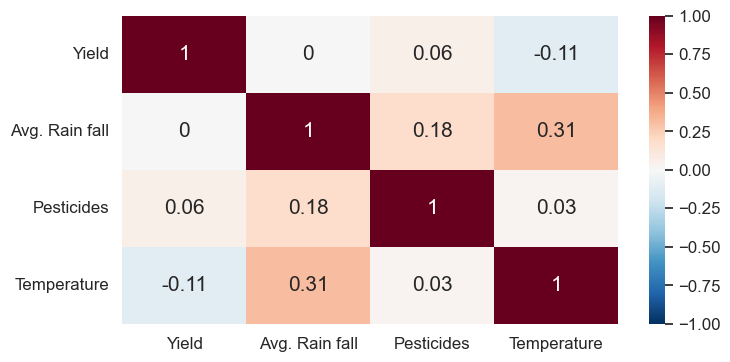

In [185]:
heatmpap_q1 = get_heatmap(yield_subset.corr())

Here we can see that rainfall (mm/year) and Hg/Ha Yield has the lowest correlation of the pairs. The largest positive correlation is between rainfall (mm/year) and average temperature. The larges negative correlation is between average temperature and rainfall (mm/year).


- Create a boxplot of the columns: 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp' **1 point**


In [13]:

def get_box_plot(data: pd.DataFrame, title='Box plot'):
    '''
    Function that creates a box plot on the given data
    Title can be changed
    '''
    fig, axs = plt.subplots(nrows=1, ncols=data.shape[1], figsize=(15, 5))

    # Plot each set of data in a different subplot
    for i in range(data.shape[1]):
        axs[i].boxplot(data.iloc[:, i], widths=0.6, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', color='black'))
        axs[i].set_title(f'{data.iloc[:,i].name}')

    fig.text(0.04, 0.5, 'Observations', rotation='vertical')
    fig.suptitle(title)
    # Increase spacing between subplots
    fig.subplots_adjust(wspace=0.4)
    return fig


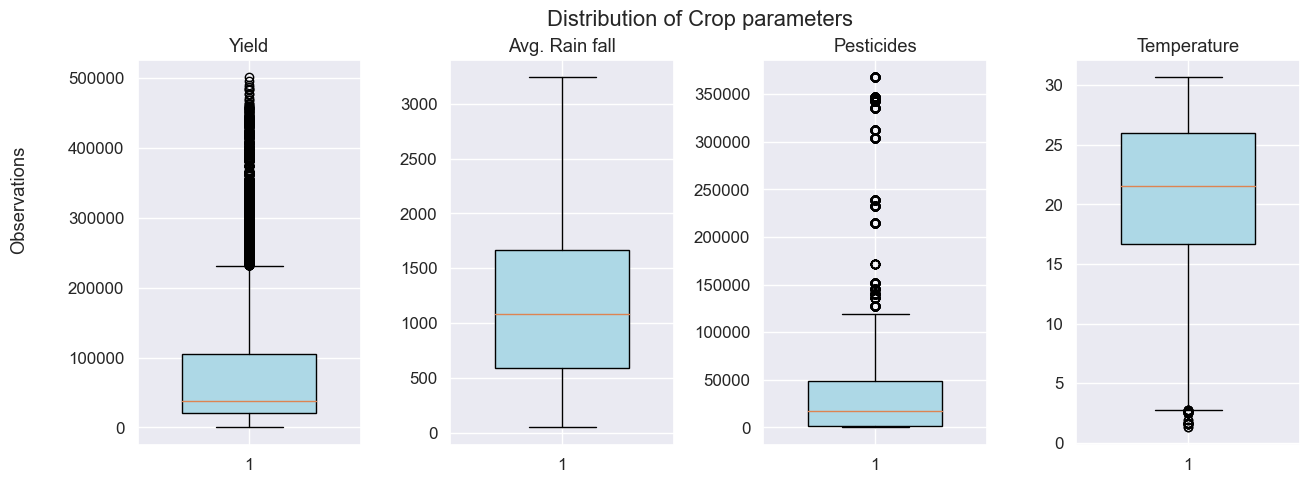

In [14]:
box_plot_q1 = get_box_plot(yield_subset, 'Distribution of Crop parameters')

- Create a pairplot of the columns: 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp' **1 point**


In [168]:
def plot_pairplot(data, title='', diag_color='red', hue=None, columns=None):
    ''' 
    Function to get pairplot, input: dataframe, title and diagonal color
    Returns plot
    '''
    if columns:
        data=data[columns]

    # Customize the diagonal plots to highlight the distribution and setting hue (if given) on given color
    plot = sns.pairplot(data, hue=hue, diag_kws={'color': diag_color})
    
    # Set the title of the plot
    plt.subplots_adjust(top=0.9)
    plot.fig.suptitle(title, fontsize=18)
    
    # Adjust the spacing between the subplots
    plot.fig.subplots_adjust(wspace=0.2, hspace=0.2)
    
    return plot

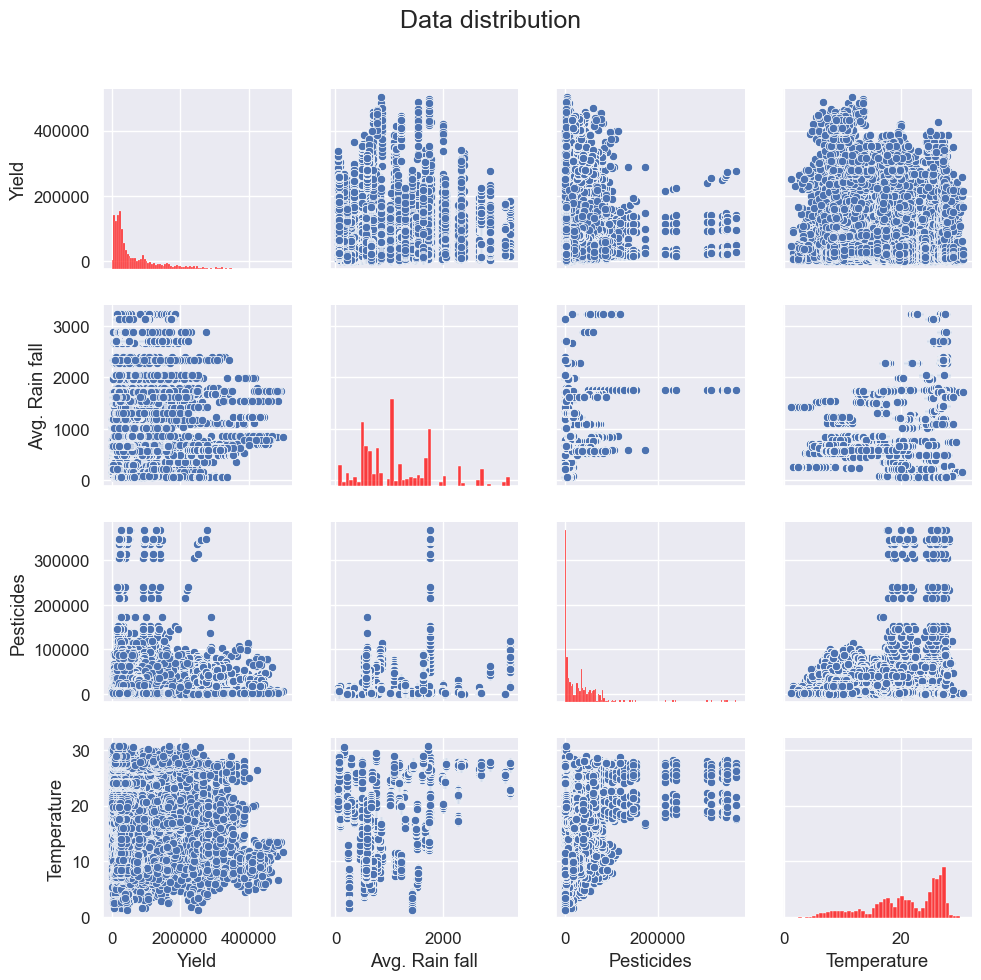

In [170]:
pair_plot_q1 = plot_pairplot(yield_subset, title='Data distribution')

On the diagonal (with a slight red color) we can see the distribution. All of them are quite skewed either left or right except rainfall (mm/year) which is more equally distributed. 


- Feel free to pursue your exploration to better understand your dataset. Although not graded, this might help you better understanding the problem and answer the following questions.


First of all i just wanted to see have all of these paremeters have changed over time. Some of them might have increased a lot the last few years, and can then also give us some information about the parameters respective importance and relationship to later predict our crop yield. Additionally i would like to check whether i have some duplicates in my data, plot its main statistics, and if its a substantial amount it might bias our data. 

In [17]:
# Getting duplicates
duplicates_to_show = yield_df.duplicated(keep=False)
duplicates = yield_df.duplicated()
duplicate_rows = duplicates[duplicates]

# Displaying duplicates
display(yield_df.loc[duplicates_to_show])
print('Number of duplicates:', duplicates.sum())

# Comparing the characteristics of the duplicated with the full data set and a dataset with removed duplicates
display('Duplicate dataset', yield_df.loc[duplicates].describe())
display('Original dataset', yield_df.describe())

yield_no_dup_df = yield_df.drop_duplicates()
display('No duplicates dataset', yield_no_dup_df.describe())


Area         Item  Year   Yield  Avg. Rain fall  Pesticides  \
2082       Bangladesh        Maize  1990   10015            2666     1266.00   
2083       Bangladesh        Maize  1990   10015            2666     1266.00   
2084       Bangladesh     Potatoes  1990   91410            2666     1266.00   
2085       Bangladesh     Potatoes  1990   91410            2666     1266.00   
2086       Bangladesh  Rice, paddy  1990   25661            2666     1266.00   
...               ...          ...   ...     ...             ...         ...   
27700  United Kingdom        Wheat  2012   66571            1220    17718.64   
27704  United Kingdom     Potatoes  2013  408993            1220    17673.46   
27705  United Kingdom     Potatoes  2013  408993            1220    17673.46   
27709  United Kingdom        Wheat  2013   73838            1220    17673.46   
27710  United Kingdom        Wheat  2013   73838            1220    17673.46   

       Temperature  
2082         25.98  
2083         25.98  
2084         25.98  
2085         25.98  
2086         25.98  
...            ...  
27700         9.55  
27704         9.57  
27705         9.57  
27709         9.57  
27710         9.57  

[4411 rows x 7 columns]

Number of duplicates: 2310


'Duplicate dataset'

Year          Yield  Avg. Rain fall    Pesticides  Temperature
count  2310.000000    2310.000000     2310.000000    2310.00000  2310.000000
mean   2001.407792   77897.516017     1173.969697   62833.06684    21.893965
std       7.006705   88365.995068      617.980031   80417.40380     4.430850
min    1990.000000    4992.000000      494.000000       0.92000     8.800000
25%    1995.000000   18935.000000      495.000000   15330.16000    18.670000
50%    2001.000000   31182.000000     1083.000000   40093.69000    23.210000
75%    2008.000000  112137.500000     1761.000000   66388.00000    25.610000
max    2013.000000  444167.000000     2702.000000  367778.00000    27.820000

'Original dataset'

Year          Yield  Avg. Rain fall     Pesticides  \
count  28242.000000   28242.000000     28242.00000   28242.000000   
mean    2001.544296   77053.332094      1149.05598   37076.909344   
std        7.051905   84956.612897       709.81215   59958.784665   
min     1990.000000      50.000000        51.00000       0.040000   
25%     1995.000000   19919.250000       593.00000    1702.000000   
50%     2001.000000   38295.000000      1083.00000   17529.440000   
75%     2008.000000  104676.750000      1668.00000   48687.880000   
max     2013.000000  501412.000000      3240.00000  367778.000000   

        Temperature  
count  28242.000000  
mean      20.542627  
std        6.312051  
min        1.300000  
25%       16.702500  
50%       21.510000  
75%       26.000000  
max       30.650000

'No duplicates dataset'

Year          Yield  Avg. Rain fall     Pesticides  \
count  25932.000000   25932.000000    25932.000000   25932.000000   
mean    2001.556455   76978.132925     1146.836688   34782.573241   
std        7.055924   84647.605552      717.391098   57228.568244   
min     1990.000000      50.000000       51.000000       0.040000   
25%     1995.000000   19996.000000      593.000000    1597.000000   
50%     2001.000000   39530.000000     1083.000000   15373.000000   
75%     2008.000000  104168.000000     1668.000000   45620.000000   
max     2013.000000  501412.000000     3240.000000  367778.000000   

        Temperature  
count  25932.000000  
mean      20.422251  
std        6.439402  
min        1.300000  
25%       16.580000  
50%       21.420000  
75%       26.060000  
max       30.650000

Our 'No Duplicate' df does not differ a lot, but when we will train a model later, we would put extra emphasis on the values that occur most frequently. We can see that the mean Pesticide $(~37077 > ~34783)$ usage got a bit lower. Because of this extra emphasis and weight to the observations we have duplicates of, i will remove them and continue working on the dataframe without duplicates. So, after discussing with Boris Thurm about these findings, we where a bit unsure how to interpret it, I tried looking up at the original data provider, and it might seem that these might not be duplicates but just approximate for different regions within a country, so I will continue with the assumption that there might be another parameter missing that differentiates these numbers. Thus i will continue with the original dataset.

So let's check the development of the Yield through time.

In [18]:
# Creating a dataframe for items ,yield according to year
yield_crop_per_year = yield_df.groupby(['Item', 'Year'])[
    'Yield'].aggregate('sum').reset_index(name='Yield')


In [19]:
def get_plotly_plot(df, x, y, title, color=None):
    '''
    Function that creates a plotly plot on given dataframe, x, y columns and title.
    Takes also a color that corresponds to a column, if not given defaults to None. 
    '''
    fig = px.line(df, x=x, y=y,
                  color=color, hover_name=y,  hover_data={x: ':.1f', y: ':.1f'})

    fig.update_layout(
        title=title,
        xaxis_title=x,
        yaxis_title=y,
        font=dict(
            family='Times New Roman',
            size=10,
            color='Black'
        )
    )
    return fig


In [20]:
crops_through_time = get_plotly_plot(
    yield_crop_per_year, 'Year', 'Yield', 'Crop yield for each crop type over time', 'Item')
crops_through_time.show()


We can see that the yield is steadily increasing for all crop types (items).

In [21]:
# Creating a dataframe for items ,yield according to year
yield_persticides_per_year = yield_df.groupby(
    ['Item', 'Year'])['Pesticides'].aggregate('sum').reset_index(name='Pesticides')


In [22]:
pesticides_through_time = get_plotly_plot(
    yield_persticides_per_year, 'Year', 'Pesticides', 'Pesticides for each crop through time', 'Item')
pesticides_through_time.show()


The pesticide usage has heavily increased!

We could also see that the data was heavily skewed, i will try to do a log transformation on the most skewed columns (Yield and Pesticides), and see if that has any impact on our predictions later.

Yield  Avg. Rain fall  Pesticides  Temperature
0      10.508159            1485    4.795791        16.37
1      11.107465            1485    4.795791        16.37
2      10.057624            1485    4.795791        16.37
3       9.433484            1485    4.795791        16.37
4       8.853665            1485    4.795791        16.37
...          ...             ...         ...          ...
28237  10.024864             657    7.843876        19.76
28238   8.028129             657    7.843876        19.76
28239   9.483568             657    7.843876        19.76
28240  10.008838             657    7.843876        19.76
28241  10.038368             657    7.843876        19.76

[28242 rows x 4 columns]

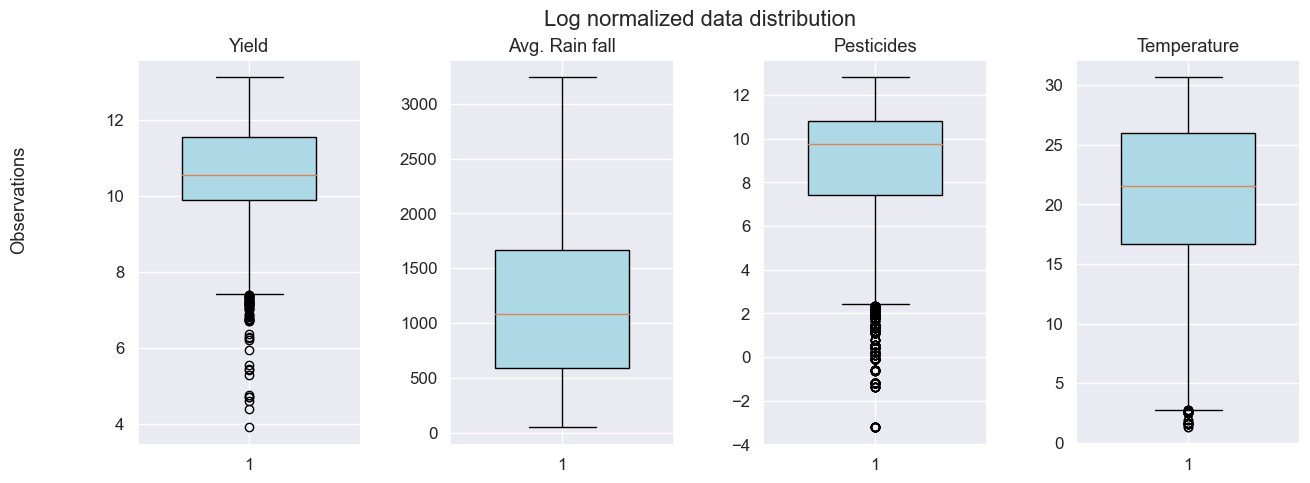

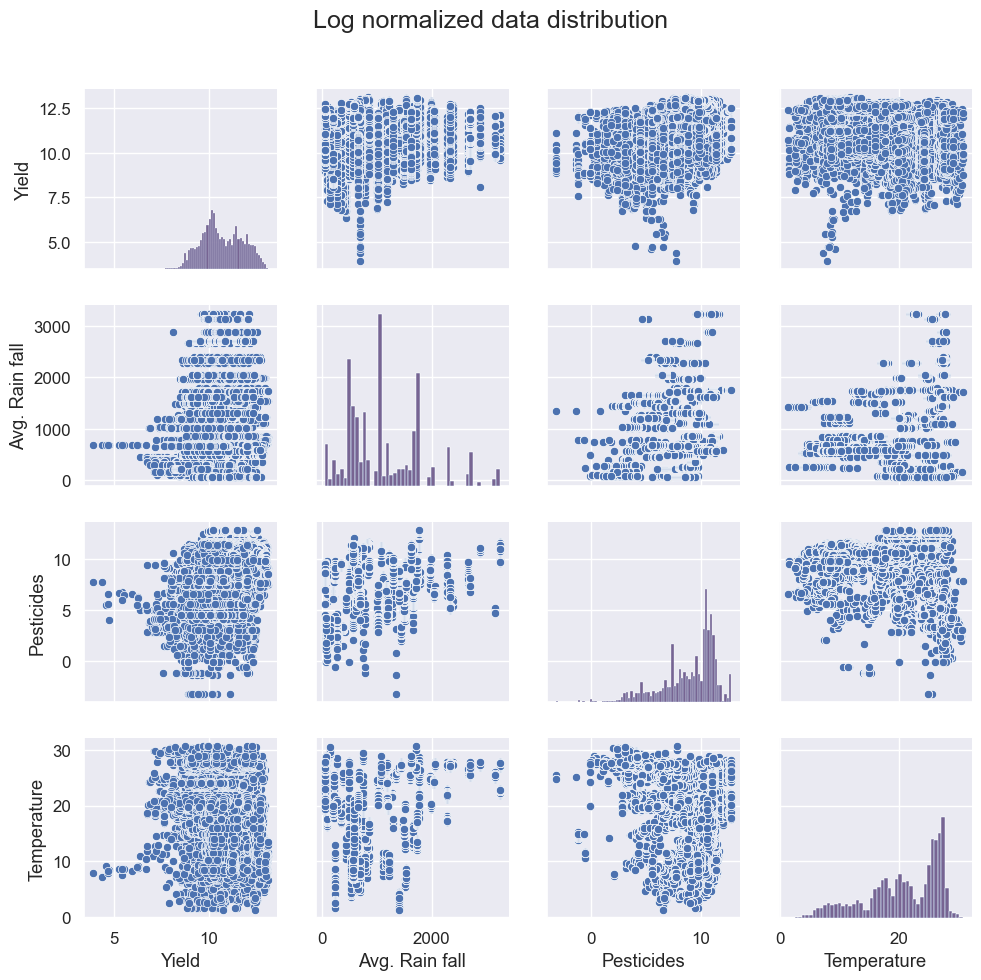

In [23]:
yield_subset_norm = yield_subset.copy()
yield_subset_norm['Yield'] = np.log(yield_subset_norm['Yield'])
yield_subset_norm['Pesticides'] = np.log(yield_subset_norm['Pesticides'])
display(yield_subset_norm)
box_plot_q1_norm = get_box_plot(yield_subset_norm, 'Log normalized data distribution')
pair_plot_q1 = plot_pairplot(yield_subset_norm, 'Log normalized data distribution')


The two plots above clearly shows that the distribution is not as aggressive anymore. I will investigate whether the log transformed data performs better in the coming question.

### Question 2: Multivariate regression

We will try to predict the crop yields (column 'hg/ha_yield') using as features: 'Item', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp'

- Extract your features and outcome **1 point**


What we are trying to predict can be explained by the following equation:

$$Yield = w_0 + w_1 * Item + w_2 * Rainfall + w_3 * Pesticides + w_4 * Temperature + \epsilon_i$$
Where $w_i$ represents the different weights we assign to the given parameters.


In [113]:
features = ['Item', 'Avg. Rain fall',
            'Pesticides', 'Temperature']

df_multi = get_df_subset(yield_df, features)


X = df_multi
y = yield_df['Yield']

# Keeping the log transformed data to check whether that can have an impact on the results later on
X_log = yield_subset_norm.copy()
X_log['Item'] = df_multi['Item'].copy()
X_log.drop(columns='Yield', inplace=True)
y_log = yield_subset_norm['Yield']

- Split between training and test set **1 point**

_Note_: Use as option: `test_size=0.2`, `random_state=42`, `shuffle=True`


In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)


- Encode the column 'Item' using `LabelEncoder` **1 point**

_Note_: After training your encoder, you need to transform the values of both the training and test set


In [115]:

print(X_train[['Item']])

# Extract the column of interest
Item = X_train[['Item']].values.ravel()
Item_test = X_test[['Item']].values.ravel()

# Define the encoder
le = LabelEncoder()

# Fit the encoder
le.fit(Item)

# Transform the train and the test set
X_train = X_train.assign(Item=le.transform(Item))
X_test = X_test.assign(Item=le.transform(Item_test))
print(X_train[['Item']])


                       Item
5493                Sorghum
10969              Soybeans
2001                Cassava
22157              Potatoes
311          Sweet potatoes
...                     ...
21575           Rice, paddy
5390   Plantains and others
860                Potatoes
15795        Sweet potatoes
23654        Sweet potatoes

[22593 rows x 1 columns]
       Item
5493      5
10969     6
2001      0
22157     3
311       7
...     ...
21575     4
5390      2
860       3
15795     7
23654     7

[22593 rows x 1 columns]


Now we have transformed the categorical variables by encoding the different 'items'.


- Rescale your features using `MinMaxScaler` **1 point**


In [116]:
def get_scaler(X_train:list, X_test:list, scaler):
    '''
    Function that returns scaled values for the input of X's and Y's, with the given scaler
    Returns a tuple with the scaled X,Y values
    '''
    scaler = scaler()
    scaler.fit(X_train)  # Fitting the scaler

    # Transform the train and the test set
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

min_max_scaler = MinMaxScaler  # Instantiating the scaler
X_train, X_test = get_scaler(X_train, X_test, min_max_scaler)


- Build and train a multivariate linear regression model **1 point**


In [28]:
# Instantiating the linear regression model
model = LinearRegression()

# Train model
model.fit(X_train, y_train)


LinearRegression()

- What is the $R^2$, mean absolute error, and mean square error on the training set? On the test set? What do you think? **1 point**


In [29]:
def get_mae_mse_r2(x, y, model) -> tuple:
    '''
    Function that given a model calculates the MAE, MSE and R-squared rounded with 3 decimals
    '''
    # Model predictions
    pred = model.predict(x)

    mae = mean_absolute_error(y, pred).round(3)
    mse = mean_squared_error(y, pred).round(3)
    r2 = r2_score(y, pred).round(2)

    return mae, mse, r2


In [30]:

def get_mae_mse_r2_df(X_train, y_train, X_test, y_test, model, column_name) -> pd.DataFrame:
    '''
    Function that returns a dataframe with the key statistical features (MAE, MSE and R-squared) on training and test set
    Uses the helper function get_mae_mse_r2()
    '''

    mae_train, mse_train, r2_train = get_mae_mse_r2(X_train, y_train, model)
    mae_test, mse_test, r2_test = get_mae_mse_r2(X_test, y_test, model)

    stat_tests_labels = ['MAE Train',
                  'MAE Test',
                  'MSE Train',
                  'MSE Test',
                  'R\u00b2 Train',
                  'R\u00b2 Test']

    df = pd.DataFrame([mae_train, mae_test, mse_train, mse_test, r2_train, r2_test],
                      index=stat_tests_labels,
                      columns=[column_name])

    return df


In [31]:
mulit_var_stats_df = get_mae_mse_r2_df(X_train, y_train, X_test, y_test, model, 1)
display(mulit_var_stats_df)


1
MAE Train  6.218846e+04
MAE Test   6.244600e+04
MSE Train  6.672605e+09
MSE Test   6.695411e+09
R² Train   7.000000e-02
R² Test    8.000000e-02

Here we can see the statistical performance of our values with the label encoder. As we know the label encoder gives each crop type its own value. Now we can check that the categorical values actual was transformed to.

In [32]:
display(np.unique(le.transform(Item)))
display(np.unique(X_train.T[0]))
display(len(np.unique(X_train.T[0])) == np.unique(le.transform(Item)))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

array([False, False, False, False, False, False, False, False, False,
       False])

At least to me it's not intuitive that we will have all the different crop types in the same dimension. Here we can see that each is mapped in the range of [0,1] with a 0.11111111 interval. I'm just thinking out loud here, but how can the model build something useful on the fact that Soybean is 0.11111111 larger than for instance Sorghum. I would assume that having one column for each crop type would provide our model more predictive power.

So to conclude, overall the $R^2$ is very low, which means that our models has a bad fit. Our model has a $R^2$ close to $0$, which means that our model is nearly better to predict than taking the average of our observations. We can also see that the $R^2$ on the training set is in absolute terms $0.01$ lower than the test set. This difference is very low and can just be explained by randomness. Both the $MAE$ and $MSE$ is slightly bigger on the test set.

It seems counter-intuitive that the $R^2$ is bigger on the test set when the $MSE$ and $MAE$ is larger as well. The reason for this is that $TSS\text{ (total sum of squares)}$ is relatively smaller than the $RSS\text{ (residual sum of squares)}$ in the test set compared to the training set.


#### Question 2.1: Multivariate regression with log transformed data
It would be interesting to see how the log transformed data will perform in this matter. So the following code does exactly the same steps but with the log-transformed data.

In [33]:
# 1. Splitting train and test set
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42, shuffle=True)

# 2. Encoding the categorical data

Item = X_train_log[['Item']].values.ravel()
Item_test_log = X_test_log[['Item']].values.ravel()
le = LabelEncoder()
le.fit(Item)
X_train_log = X_train_log.assign(Item=le.transform(Item))
X_test_log = X_test_log.assign(Item=le.transform(Item_test_log))

# 3. Scaling data
X_train_log, X_test_log = get_scaler(X_train_log, X_test_log, min_max_scaler)

# 4. Building and train model
model_log = LinearRegression()
model_log.fit(X_train_log, y_train_log)

# 5. Testing model
mulit_var_stats_df_log = get_mae_mse_r2_df(X_train_log, y_train_log, X_test_log, y_test_log, model_log, 1)

multi_var_comparison = mulit_var_stats_df.copy()
multi_var_comparison.rename(columns={1: 'Absolute'}, inplace=True)
multi_var_comparison['Log transformed'] = mulit_var_stats_df_log
display(multi_var_comparison)
 

Absolute  Log transformed
MAE Train  6.218846e+04             0.88
MAE Test   6.244600e+04             0.89
MSE Train  6.672605e+09             1.10
MSE Test   6.695411e+09             1.10
R² Train   7.000000e-02             0.11
R² Test    8.000000e-02             0.10

We can see that the $R^2$ is slightly better for the log transformed data, but when some data is in log and other i absolute numbers, it's harder to interpret.

### Question 3: Polynomial features regression

We will try to improve the quality of our prediction using `PolynomialFeatures`.

- Write a function that is using as inputs the degree of polynomial features (an integer), the training and test set (for your features and outcome), and return the $R^2$, mean absolute error, and mean square error on the training and on the set of a polynomial feature regression **3 points**

_Hint:_ You do not need to include in your function the splitting, encoding and scaling since we will reuse the ones set created before (as before). Your function should transform your training and test set to integrate polynomial features, then build and train your model, before calculating the various error metrics.


In [117]:
def get_poly_transform(X_train, X_test, degrees) -> tuple:
    '''
    Helper function to get polynomial transformation returns tuple with train and test set
    '''
    model_poly = PolynomialFeatures(degrees)
    X_train_poly = model_poly.fit_transform(X_train)
    X_test_poly = model_poly.transform(X_test)
    return X_train_poly, X_test_poly


In [131]:

def get_poly_stats(degrees, X_train, y_train, X_test, y_test, additonal_title='') -> pd.DataFrame:
    '''
    Function that create model using get_poly_transform() and trains the model with the given data
    Returns a dataframe with  key statistical characteristics s.a.a MAE, MSE, R^2 using get_mae_mse_r2_df()
    '''

    X_train_poly, X_test_poly = get_poly_transform(
        X_train, X_test, degrees)

    # Setting up the model
    model_poly = LinearRegression(fit_intercept=False)

    # Fit
    model_poly.fit(X_train_poly, y_train)

    # Now we can reuse the previous made functions to get the MAE, MSE and R^2
    return get_mae_mse_r2_df(X_train_poly, y_train, X_test_poly, y_test, model_poly, f'Poly Degree: {degrees} ({additonal_title})')


- What are the the $R^2$, mean absolute error, and mean square error on the training and on the set of a polynomial features regression with degree = 3? With degree = 7? **1 point**


In [119]:
poly_stats_df_3 = get_poly_stats(3, X_train, y_train, X_test, y_test)
poly_stats_df_7 = get_poly_stats(7, X_train, y_train, X_test, y_test)

display(poly_stats_df_3)
display(poly_stats_df_7)


Poly Degree: 3
MAE Train    5.725729e+04
MAE Test     5.723077e+04
MSE Train    5.649954e+09
MSE Test     5.640627e+09
R² Train     2.200000e-01
R² Test      2.200000e-01

Poly Degree: 7
MAE Train    2.825673e+04
MAE Test     2.896087e+04
MSE Train    1.508478e+09
MSE Test     1.554395e+09
R² Train     7.900000e-01
R² Test      7.900000e-01

- Plot the evolution of the MSE on the training set for a polynomial feature regression model when the degree goes from 2 to 10. On the same figure, plot the MSE on the test set for a polynomial feature regression model, when the degree goes from 2 to 10. Which degree would you choose and why? **2 points**


In [120]:
one_to_ten = np.linspace(1, 10, num=10, dtype='int')
df_stats_poly_one_ten = pd.DataFrame([])
df_stats_poly_one_ten_log = pd.DataFrame([])


def df_string_display(df, decimals):
    '''
    Function to display with chosen decimals in string format for readability
    '''
    return df.apply(lambda x: x.round(decimals).astype(str))


# Looping from 1-10 to get the stats for each polynomial degree
for i in one_to_ten:
    df_stats_poly_one_ten[i] = get_poly_stats(
        i, X_train, y_train, X_test, y_test)
    # Doing the same with the log transformed data to check if it makes a difference
    df_stats_poly_one_ten_log[i] = get_poly_stats(
        i, X_train_log, y_train_log, X_test_log, y_test_log)

# Displaying with 2 decimals in string format for readability
display(df_string_display(df_stats_poly_one_ten, 2))


1              2              3              4   \
MAE Train       62188.46       61542.79       57257.29       54561.36   
MAE Test         62446.0        61907.9       57230.77        54133.2   
MSE Train  6672605138.11  6514135166.29  5649953904.49  5050876367.84   
MSE Test   6695410825.85  6557752058.46  5640626612.97  4999968178.49   
R² Train            0.07            0.1           0.22            0.3   
R² Test             0.08            0.1           0.22           0.31   

                      5              6              7              8   \
MAE Train       46836.45       31233.64       28256.73       24135.91   
MAE Test        46605.04       31857.26       28960.87        25177.1   
MSE Train  3839432556.29  1863230935.86  1508477898.62  1194935128.83   
MSE Test   3846931346.34  1901134900.54   1554394778.2  1282157237.81   
R² Train            0.47           0.74           0.79           0.83   
R² Test             0.47           0.74           0.79           0.82   

                      9              10  
MAE Train       18692.57       16561.68  
MAE Test        19840.66       17929.39  
MSE Train   860581354.79   712273415.79  
MSE Test   1023542913.09  1074784636.62  
R² Train            0.88            0.9  
R² Test             0.86           0.85

Now we have a dataframe with all the data we need to plot the development. I will create a plot for the $MSE$, to see more easily compare the log transformed data with the .


In [121]:

def get_plot_with_traces(df: pd.DataFrame, y_list, title) -> go.Figure:
    '''
    Function that returns a graph with multiple traces, input is a dataframe and a list of the y-traces to be plotted along with title
    '''
    # Define the x and y values
    x = df.columns.values
    trace_list = []

    for y in y_list:
        trace = go.Scatter(
            x=x, y=y.values,
            mode='lines+markers',
            name=y.name,
            hovertemplate='Polynomial degree: %{x}<br>%{y}',
            marker=dict(size=8),
            line=dict(
                width=2,
            )
        )
        trace_list.append(trace)

    # Add axis labels and a title
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Polynomial degrees'),
        yaxis=dict(title='R\u00b2'),
        legend=dict(x=1, y=-0.2),
        autosize=True
    )

    # Create a figure
    return go.Figure(data=trace_list, layout=layout)


In [122]:


# Define the x and y values
y1 = df_stats_poly_one_ten.iloc[-4,1:]  # Getting the fourth last row : MSE train
y2 = df_stats_poly_one_ten.iloc[-3,1:]  # Getting the third last row : MSE test

fig = get_plot_with_traces(df_stats_poly_one_ten.iloc[:, 1:], y_list=[
#fig = get_plot_with_traces(df_stats_poly_one_ten, y_list=[
                           y1, y2], title='MSE for different polynomial degrees')
fig.update_layout(yaxis=dict(title='MSE'))
fig.show()


In [123]:

# Define the x and y values
y_log_1 = df_stats_poly_one_ten_log.iloc[-4,1:]  # Getting the fourth last row : MSE train
y_log_2 = df_stats_poly_one_ten_log.iloc[-3,1:]  # Getting the third last row : MSE test

fig_log = get_plot_with_traces(df_stats_poly_one_ten_log.iloc[:, 1:], y_list=[
                           y_log_1, y_log_2], title='MSE for different polynomial degrees (log transformed)')
fig_log.update_layout(yaxis=dict(title='MSE'))
fig_log.show()


Here we can clearly see that the $R^2$ increases a lot for every iteration towards a polynomial degree of 6. After 6, it diverges as our model is getting too 'specialized' and lacking generalization. But when our features get larger than the number of observation there's an increasing chance of overfitting. 

Let's say that:
$$\text{d = degree, m = features, n=observations, and k = "new" number of features}$$
We know that the amount of polynomial features (k) are given as:
$$ k =\begin{pmatrix}d+m\\d\end{pmatrix} = \frac{(d + m)!}{(d! * m!)}.$$



Scikit uses the L-FBGS algorithm with time complexity  $O(k*m)$. Where $m$ is a number describing the memory (typically 5-30), but the essence is that the running time is highly dependent on number of features ($k$). 
I would therefor choose 6, which matches the "elbow" of $MSE$ ('MSE for different polynomial degrees') of the graph plotted earlier. With $d=6$ and $m=4$ we get to following amount of new features ($k$), which should be computational "feasible".
$$\text{Polynomial Degree} = 6$$
$$ k =\begin{pmatrix}6+4\\6\end{pmatrix} = \frac{(6 + 4)!}{(6! * 4!)} = 210$$


Sources:
- http://www.people.vcu.edu/~ysong3/lecture8.pdf
- https://aip.scitation.org/doi/pdf/10.1063/1.4995124
- https://en.wikipedia.org/wiki/Limited-memory_BFGS



For curiosity sake, and since I have made  a generic function to plot several traces, we can easily plot the $R^2$ of both our log and "normal" data.

In [124]:
# Rename for readability in graph

y1 = df_stats_poly_one_ten.iloc[-2]  # Getting the second last row : R^2 train
y2 = df_stats_poly_one_ten.iloc[-1]  # Getting the  last row : R^2 test
y3 = df_stats_poly_one_ten_log.iloc[-1]
y4 = df_stats_poly_one_ten_log.iloc[-2]

df_stats_poly_one_ten_log.rename(
    index={'R\u00b2 Train': 'R\u00b2 Train (Log)'}, inplace=True)
df_stats_poly_one_ten_log.rename(
    index={'R\u00b2 Test': 'R\u00b2 Test (Log)'}, inplace=True)

# Create a list to feed the plot function for the traces i want to display
y_values_to_be_traced = [y1, y2, y3, y4]

r2_plot_comparison = get_plot_with_traces(df_stats_poly_one_ten, y_list=y_values_to_be_traced,
                                          title='R\u00b2 for different polynomial degrees (including log transformed)')
r2_plot_comparison.show()


From this graph we can see that the log normalized data doesn't really outperform the absolute values even though it performs slightly better except at polynomial degree 4, where they are approximately the same. For simplicity, and easier interpretation i will remain with the original data format.

### Question 4: Ridge and cross-validation

- Build, train, and evaluate a polynomial features regression model, with Ridge regularization, and cross validation. For number of degree, select the one that you picked before. How does your new model compares to your previous one? **3 points**


In [125]:

# Use helper function to get poly transformation for the chosen polynomial degrees
X_train_poly_ridge, X_test_poly_ridge = get_poly_transform(X_train, X_test, 6)

# Set up the model
ridge_model = Ridge(alpha=1, fit_intercept=False, max_iter=1000)
ridge_model_zero = Ridge(alpha=0, fit_intercept=False, max_iter=1000)

# Use fit
ridge_model.fit(X_train_poly_ridge, y_train)
ridge_model_zero.fit(X_train_poly_ridge, y_train)

# Getting the key stats df
ridge_stats = get_mae_mse_r2_df(
    X_train_poly_ridge, y_train, X_test_poly_ridge, y_test, ridge_model, 'Ridge Model (Alpha=1)')

ridge_stats_zero = get_mae_mse_r2_df(
    X_train_poly_ridge, y_train, X_test_poly_ridge, y_test, ridge_model_zero, 'Ridge Model (Alpha=0)')

# Displaying with 2 decimals in string format for readability
display(df_string_display(ridge_stats, 2))
display(df_string_display(ridge_stats_zero, 2))


Ridge Model (Alpha=1)
MAE Train              56558.66
MAE Test               56348.34
MSE Train         5515700271.79
MSE Test          5490527912.32
R² Train                   0.23
R² Test                    0.24

Ridge Model (Alpha=0)
MAE Train              31233.64
MAE Test               31857.26
MSE Train         1863230935.86
MSE Test           1901134889.3
R² Train                   0.74
R² Test                    0.74

The results where not very impressive by the ridge regularization, but ridge punishes the test data quite substantially since the regularization parameter $\alpha$ has a large impact on $MAE$ and $MSE$ (in the test data). When `alpha = 0`, the objective is equivalent to ordinary least
squares. Thus when $\alpha$ is approaching $0$, our $R^2$ approaches $0.77$ which is what we got with our 7 degree polynomial prediction.

Now we can compare these statistics with the previous created df called `df_stats_poly_one_ten` where we have the performance metrics for $\text{Polynomial Degree}: 1-10$.


In [126]:
poly_and_ridge_comparison_df = df_stats_poly_one_ten.copy()
poly_and_ridge_comparison_df[ridge_stats.columns[0]] = ridge_stats
poly_and_ridge_comparison_df[ridge_stats_zero.columns[0]] = ridge_stats_zero
display(df_string_display(poly_and_ridge_comparison_df, 3))


1              2              3              4  \
MAE Train       62188.46       61542.79       57257.29       54561.36   
MAE Test         62446.0        61907.9       57230.77        54133.2   
MSE Train  6672605138.11  6514135166.29  5649953904.49  5050876367.84   
MSE Test   6695410825.85  6557752058.46  5640626612.97  4999968178.49   
R² Train            0.07            0.1           0.22            0.3   
R² Test             0.08            0.1           0.22           0.31   

                       5              6              7              8  \
MAE Train       46836.45       31233.64       28256.73       24135.91   
MAE Test        46605.04       31857.26       28960.87        25177.1   
MSE Train  3839432556.29  1863230935.86  1508477898.62  1194935128.83   
MSE Test   3846931346.34  1901134900.54   1554394778.2  1282157237.81   
R² Train            0.47           0.74           0.79           0.83   
R² Test             0.47           0.74           0.79           0.82   

                       9             10 Ridge Model (Alpha=1)  \
MAE Train       18692.57       16561.68              56558.66   
MAE Test        19840.66       17929.39              56348.34   
MSE Train   860581354.79   712273415.79         5515700271.79   
MSE Test   1023542913.09  1074784636.62         5490527912.32   
R² Train            0.88            0.9                  0.23   
R² Test             0.86           0.85                  0.24   

          Ridge Model (Alpha=0)  
MAE Train              31233.64  
MAE Test               31857.26  
MSE Train         1863230935.86  
MSE Test           1901134889.3  
R² Train                   0.74  
R² Test                    0.74

As we saw above, the results have not improved, in addition to the way $\alpha$ punishes it it might be that the way we transformed our categorical data with LabelEncoding is not the optimal.


Now let's use K-fold cross validation and see if our score improves. Just to showcase the best alpha, we can use the parameter `alphas` for the cross-validation to find the best alpha. The parameter has to be $>0$, so we can start with something really small such as $1*10^{-10}$ and create a evenly spaced interval up to $100$. We can also report the best $\alpha$ to verify our findings.


In [127]:
# Set up the model
ridge_cv_model = RidgeCV(alphas=np.linspace(
    1e-10, 100, 20), cv=5, fit_intercept=False)

# Use fit and the previous created X-values, the y stays the same
ridge_cv_model.fit(X_train_poly_ridge, y_train)

ridge_cv_stats = get_mae_mse_r2_df(
    X_train_poly_ridge, y_train, X_test_poly_ridge, y_test, ridge_cv_model, 'Ridge-CV Model')

display(df_string_display(ridge_cv_stats, 2))
print(f'Alpha used: {ridge_cv_model.alpha_}')


Ridge-CV Model
MAE Train       31233.14
MAE Test        31856.83
MSE Train   1863231448.2
MSE Test   1901135343.89
R² Train            0.74
R² Test             0.74

Alpha used: 1e-10


Again, our results did not improve, and our model chose the smallest $\alpha = 1*10^{-10}$, which means that we are (almost) not regularizing at all, and our model objective is equivalent to ordinary least squares demonstrated by our results in the `Multivariate LinearRegression`... So we might need to encode our categorical data better.


In [128]:

# Using the previous created function to display in nicer format
display(df_string_display(poly_and_ridge_comparison_df, 2))


1              2              3              4  \
MAE Train       62188.46       61542.79       57257.29       54561.36   
MAE Test         62446.0        61907.9       57230.77        54133.2   
MSE Train  6672605138.11  6514135166.29  5649953904.49  5050876367.84   
MSE Test   6695410825.85  6557752058.46  5640626612.97  4999968178.49   
R² Train            0.07            0.1           0.22            0.3   
R² Test             0.08            0.1           0.22           0.31   

                       5              6              7              8  \
MAE Train       46836.45       31233.64       28256.73       24135.91   
MAE Test        46605.04       31857.26       28960.87        25177.1   
MSE Train  3839432556.29  1863230935.86  1508477898.62  1194935128.83   
MSE Test   3846931346.34  1901134900.54   1554394778.2  1282157237.81   
R² Train            0.47           0.74           0.79           0.83   
R² Test             0.47           0.74           0.79           0.82   

                       9             10 Ridge Model (Alpha=1)  \
MAE Train       18692.57       16561.68              56558.66   
MAE Test        19840.66       17929.39              56348.34   
MSE Train   860581354.79   712273415.79         5515700271.79   
MSE Test   1023542913.09  1074784636.62         5490527912.32   
R² Train            0.88            0.9                  0.23   
R² Test             0.86           0.85                  0.24   

          Ridge Model (Alpha=0)  
MAE Train              31233.64  
MAE Test               31857.26  
MSE Train         1863230935.86  
MSE Test           1901134889.3  
R² Train                   0.74  
R² Test                    0.74

### Question 5: One-Hot encoding

We will check how the encoding influenced our results.

- Split your original dataset between training and test set (using the same parameters as in Question 2). This time, encode the column 'Item' using `OneHotEncoder`. Finally, rescale your features. **1 point**


In [46]:
# Creating function to do One-Hot encoding, takes a dataframe and the column to encode
# Returns the new dataframe

def get_ohe(df, column) -> pd.DataFrame:
    '''
    Function that takes a dataframe and one-hot encodes the given column
    '''
    ohe = OneHotEncoder()  # Instantiating the OneHotEncoder (ohe)
    ohe.fit(df[[column]])  # Fitting the ohe on the given column

    # Transforming the given column into a one-hot encoded matrix
    ohm = ohe.transform(df[[column]]).toarray()
    one_hot_df = pd.DataFrame(  # Creating a new DataFrame with the one-hot encoded matrix and column names
        ohm, columns=ohe.get_feature_names_out([column]))

    one_hot_df = one_hot_df.reset_index(drop=True)
    # Concatenate the one-hot encoded DataFrame with the original DataFrame
    df_ret = pd.concat([df.reset_index(drop=True), one_hot_df], axis=1)

    df_ret.drop(column, axis=1, inplace=True)  # Drop the original column
    return df_ret


# Creating a copy of our X's to keep things clean
X_ohe = X.copy()

# Splitting data before encoding to avoid data leakage
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y, test_size=0.2, random_state=42, shuffle=True)

# Calling the One-Hot encoding function
X_train_ohe = get_ohe(X_train_ohe, 'Item')
X_test_ohe = get_ohe(X_test_ohe, 'Item')


In [47]:

# Now we can rescale our features using our previously  defined MinMaxScaler function
min_max_scaler = MinMaxScaler
X_train_ohe, X_test_ohe = get_scaler(X_train_ohe, X_test_ohe, min_max_scaler)


- Build, train, and evaluate a polynomial features regression model, with the same number of degrees as before, but this time with the one-hot encoded data. How does your model compares to the polynomial features regression model (Question 3)? **2 points**


Now, with the one-hot encoder we have added a lot of new features to our model, which increases the time complexity of our model. Hence, we either could (1) reduce the number of features, by removing those with little correlation, (2) reduce the number of polynomial degrees or (3) reduce the sample size. I will try to discover a combination of these strategies. So the number of features will now be:
$$\text{Polynomial Degree} = 6$$
$$ k =\begin{pmatrix}6+13\\6\end{pmatrix} = \frac{(19)!}{(6! * 13!)} = 27132$$
which is more than 100 times larger than our previous model with 220 features. So the first thing i tried was to use the `RFE` which reduces the size of the features by excluding the least important features. I will build the degrees up and see how much is tolerated in regards to time spent...


In [107]:

# Perform feature selection on training data using RFE
model = LinearRegression()

# Showcasing poly degree 5 and 50 features
rfe = RFE(model, n_features_to_select=50)
X_train_reduced = rfe.fit_transform(X_train_ohe, y_train_ohe)
ohe_poly_selected_df = get_poly_stats(5, X_train_reduced,  y_train_ohe, rfe.transform(X_test_ohe), y_test_ohe, additonal_title='- OHE')
ohe_poly_selected_df


Poly Degree: 5
MAE Train    1.931085e+04
MAE Test     1.997692e+04
MSE Train    1.123843e+09
MSE Test     1.186989e+09
R² Train     8.400000e-01
R² Test      8.400000e-01


I found that keeping 50 features and using 5 degree ran in 1.75 minutes and gave an $R^2=8.4$ which is quite a lot better than our polynomial feature model with the same amount of degrees which gave: $PolyModel(5)=>R^2=0,47$. I tried playing around with degree 6 on the one-hot encoded data, but i had to reduce the features to the point where it performed poorer than the 5-degree model.

Another strategy would be to reduce the training set and see if we could keep the polynomial degree. Intuitively this would not reduce the running time that much, since it's the total amount of features that really punishes the running time. But let's try to see if we can do degree 6 by reducing both the set we built our model on and reduce the number of features. I tried by reducing the training set by 50% and only keep the top 10 features. It should run in a little over a minute...

In [104]:

# Reducing the sets
X_train_small, X_test, y_train_small, y_test = train_test_split(X_ohe, y, train_size=0.5, random_state=42)
X_train_ohe_small, X_test_ohe_small, y_train_ohe_small, y_test_ohe_small = train_test_split(X_train_small, y_train_small, test_size=0.2, random_state=42, shuffle=True)

# Calling the One-Hot encoding function
X_train_ohe_small = get_ohe(X_train_ohe_small, 'Item')
X_test_ohe_small = get_ohe(X_test_ohe_small, 'Item')

# Now we can rescale our features using our previously  defined get_scaler function
min_max_scaler = MinMaxScaler
X_train_ohe_small, X_test_ohe_small = get_scaler(X_train_ohe_small, X_test_ohe_small, min_max_scaler)

# Reducing the amount of features
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_train_ohe_small = rfe.fit_transform(X_train_ohe_small, y_train_ohe_small)

# Testing model and getting results
ohe_poly_double_reduced_df = get_poly_stats(6, X_train_ohe_small,  y_train_ohe_small, rfe.transform(X_test_ohe_small), y_test_ohe_small)
ohe_poly_double_reduced_df


Poly Degree: 6
MAE Train    2.337616e+04
MAE Test     2.295187e+04
MSE Train    1.620629e+09
MSE Test     1.614441e+09
R² Train     7.700000e-01
R² Test      7.700000e-01

This should run in under a minute, and it gives an $R^2=0.77$. Reducing the data that the model get to train on seems not to work very well. So to sum up, lets compare the best scoring model here with the one we obtained in Question 3.

In [129]:

encoder_comparison_df = pd.concat([get_poly_stats(
    5, X_train, y_train, X_test, y_test), ohe_poly_selected_df], axis=1)


display(encoder_comparison_df)


Poly Degree: 5  Poly Degree: 5
MAE Train    4.683645e+04    1.931085e+04
MAE Test     4.660504e+04    1.997692e+04
MSE Train    3.839433e+09    1.123843e+09
MSE Test     3.846931e+09    1.186989e+09
R² Train     4.700000e-01    8.400000e-01
R² Test      4.700000e-01    8.400000e-01

We see that the one-hot encoder with 50 of the "best" features on polynomial degree 5 outperforms the one obtained in Q3. So - the `OneHotEncoder` performs much better than the `LabelEncoder`, and the Ridge and RidgeCV model with the LabelEncoded values of `Item`.

## Classification

Access to safe drinking-water is essential to health, a basic human right and a component of effective policy for health protection. However, for a least 3 billion people, the quality of the water they depend on is unknown due to a lack of monitoring (see [SDG Goal 6](https://sdgs.un.org/goals/goal6) 'Ensure availability and sustainable management of water and sanitation for all').

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Sustainable_Development_Goal_6.png/800px-Sustainable_Development_Goal_6.png' width='200'>

We will use data from the [Water Quality](https://www.kaggle.com/datasets/mssmartypants/water-quality) dataset to try to predict whether the water is safe to drink depending on the concentration of various minerals and microorganisms. Check the webpage to read a description of the features and get a better understanding of our problem.


### Question 6: Load and Discover the dataset


- Load the data in a dataframe. The url link is provided below. Display the first 10 observations and the types of data


In [150]:
url_water = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/waterQuality1.csv'
water_df = pd.read_csv(url_water)

display(water_df.head(10))
display(water_df.dtypes)


aluminium  ammonia  arsenic  barium  cadmium  chloramine  chromium  copper  \
0       1.65     9.08     0.04    2.85    0.007        0.35      0.83    0.17   
1       2.32    21.16     0.01    3.31    0.002        5.28      0.68    0.66   
2       1.01    14.02     0.04    0.58    0.008        4.24      0.53    0.02   
3       1.36    11.33     0.04    2.96    0.001        7.23      0.03    1.66   
4       0.92    24.33     0.03    0.20    0.006        2.67      0.69    0.57   
5       0.94    14.47     0.03    2.88    0.003        0.80      0.43    1.38   
6       2.36     5.60     0.01    1.35    0.004        1.28      0.62    1.88   
7       3.93    19.87     0.04    0.66    0.001        6.22      0.10    1.86   
8       0.60    24.58     0.01    0.71    0.005        3.14      0.77    1.45   
9       0.22    16.76     0.02    1.37    0.007        6.40      0.49    0.82   

   flouride  bacteria  ...   lead  nitrates  nitrites  mercury  perchlorate  \
0      0.05      0.20  ...  0.054     16.08      1.13    0.007        37.75   
1      0.90      0.65  ...  0.100      2.01      1.93    0.003        32.26   
2      0.99      0.05  ...  0.078     14.16      1.11    0.006        50.28   
3      1.08      0.71  ...  0.016      1.41      1.29    0.004         9.12   
4      0.61      0.13  ...  0.117      6.74      1.11    0.003        16.90   
5      0.11      0.67  ...  0.135      9.75      1.89    0.006        27.17   
6      0.33      0.13  ...  0.021     18.60      1.78    0.007        45.34   
7      0.86      0.16  ...  0.197     13.65      1.81    0.001        53.35   
8      0.98      0.35  ...  0.167     14.66      1.84    0.004        23.43   
9      1.24      0.83  ...  0.109      4.79      1.46    0.010        30.42   

   radium  selenium  silver  uranium  is_safe  
0    6.78      0.08    0.34     0.02        1  
1    3.21      0.08    0.27     0.05        1  
2    7.07      0.07    0.44     0.01        0  
3    1.72      0.02    0.45     0.05        1  
4    2.41      0.02    0.06     0.02        1  
5    5.42      0.08    0.19     0.02        1  
6    2.84      0.10    0.24     0.08        0  
7    7.24      0.08    0.08     0.07        0  
8    4.99      0.08    0.25     0.08        1  
9    0.08      0.03    0.31     0.01        1  

[10 rows x 21 columns]

aluminium      float64
ammonia        float64
arsenic        float64
barium         float64
cadmium        float64
chloramine     float64
chromium       float64
copper         float64
flouride       float64
bacteria       float64
viruses        float64
lead           float64
nitrates       float64
nitrites       float64
mercury        float64
perchlorate    float64
radium         float64
selenium       float64
silver         float64
uranium        float64
is_safe          int64
dtype: object

- Display summary statistics of your dataset and a heatmap of your correlation matrix **1 point**


aluminium      ammonia      arsenic       barium      cadmium  \
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000   
mean      0.666396    14.278212     0.161477     1.567928     0.042803   
std       1.265323     8.878930     0.252632     1.216227     0.036049   
min       0.000000    -0.080000     0.000000     0.000000     0.000000   
25%       0.040000     6.577500     0.030000     0.560000     0.008000   
50%       0.070000    14.130000     0.050000     1.190000     0.040000   
75%       0.280000    22.132500     0.100000     2.482500     0.070000   
max       5.050000    29.840000     1.050000     4.940000     0.130000   

        chloramine     chromium       copper     flouride     bacteria  ...  \
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000  ...   
mean      2.177589     0.247300     0.805940     0.771646     0.319714  ...   
std       2.567210     0.270663     0.653595     0.435423     0.329497  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.100000     0.050000     0.090000     0.407500     0.000000  ...   
50%       0.530000     0.090000     0.750000     0.770000     0.220000  ...   
75%       4.240000     0.440000     1.390000     1.160000     0.610000  ...   
max       8.680000     0.900000     2.000000     1.500000     1.000000  ...   

              lead     nitrates     nitrites      mercury  perchlorate  \
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000   
mean      0.099431     9.819250     1.329846     0.005193    16.465266   
std       0.058169     5.541977     0.573271     0.002967    17.688827   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.048000     5.000000     1.000000     0.003000     2.170000   
50%       0.102000     9.930000     1.420000     0.005000     7.745000   
75%       0.151000    14.610000     1.760000     0.008000    29.487500   
max       0.200000    19.830000     2.930000     0.010000    60.010000   

            radium     selenium       silver      uranium      is_safe  
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000  
mean      2.920106     0.049684     0.147811     0.044672     0.114057  
std       2.322805     0.028773     0.143569     0.026906     0.317900  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.820000     0.020000     0.040000     0.020000     0.000000  
50%       2.410000     0.050000     0.080000     0.050000     0.000000  
75%       4.670000     0.070000     0.240000     0.070000     0.000000  
max       7.990000     0.100000     0.500000     0.090000     1.000000  

[8 rows x 21 columns]

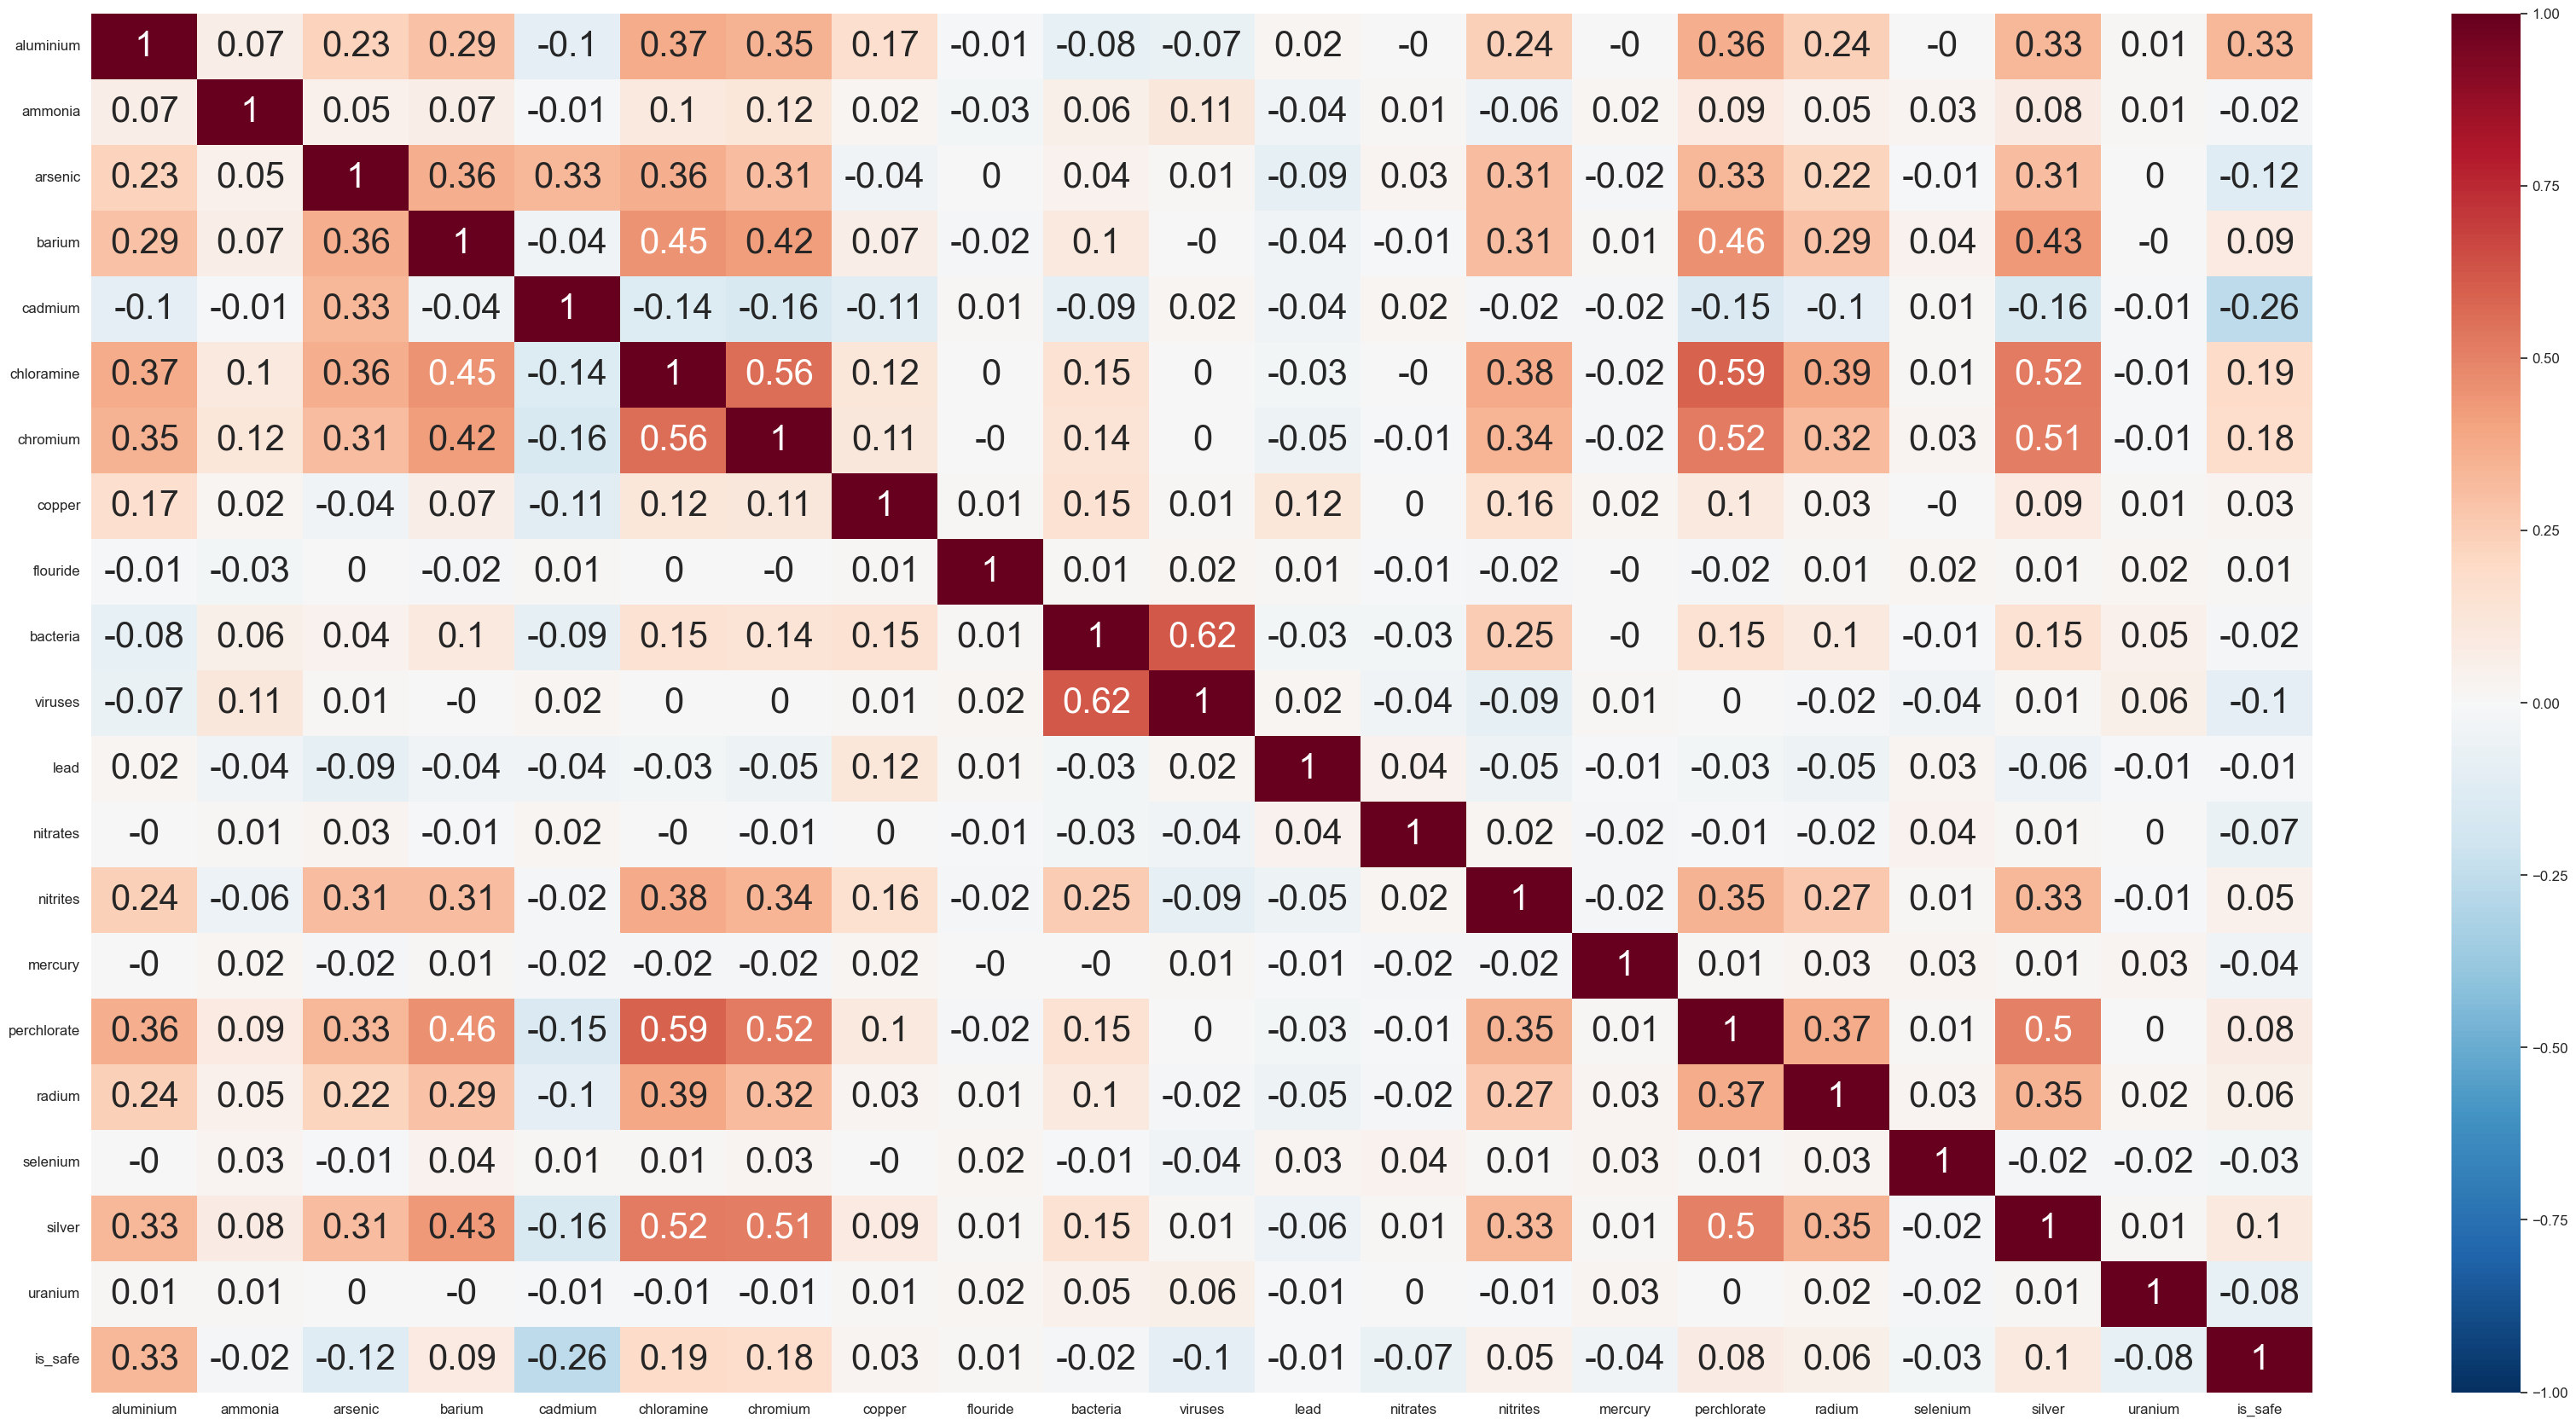

In [151]:
display(water_df.describe())
heat_map_q6 = get_heatmap(water_df.corr(), annot_size=30)


- Create a pairplot including the columns 'arsenic', 'cadmium', 'chromium', 'copper', 'bacteria', 'viruses', 'lead', 'nitrates', 'mercury'; and color by the class 'is_safe' **1 points**


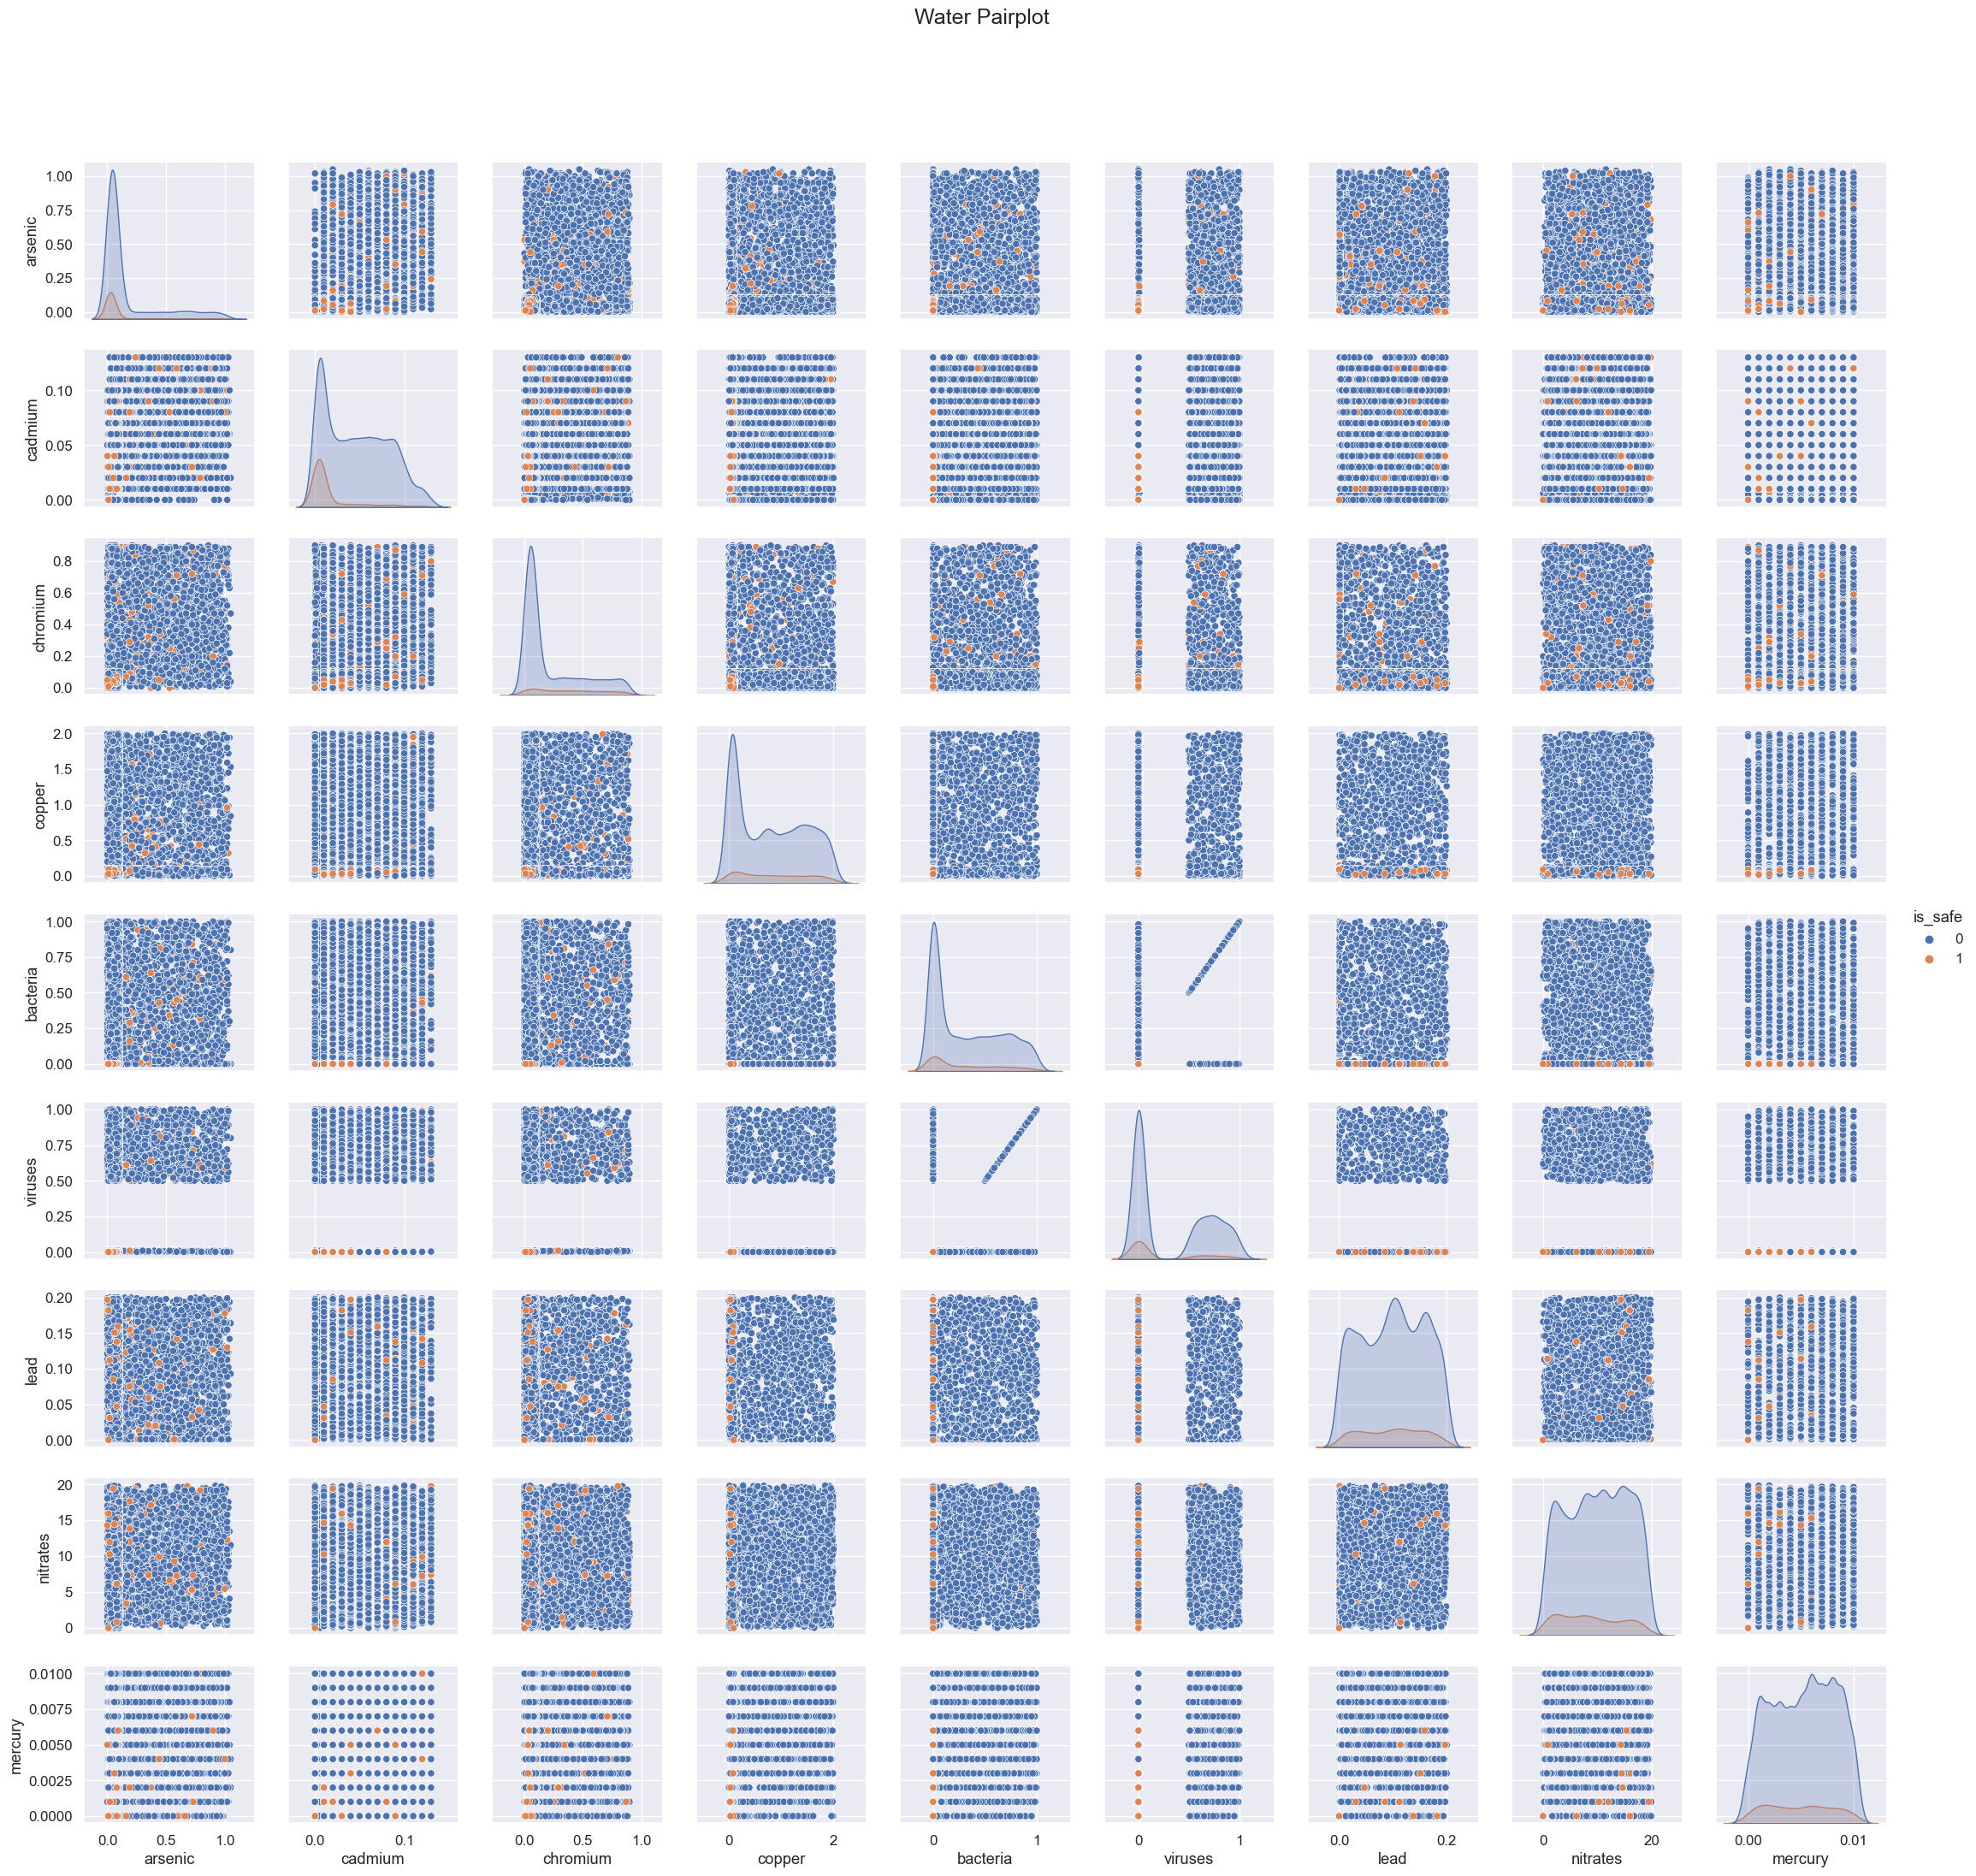

In [171]:

# Features and outcome 
cols_classification = ['arsenic', 'cadmium', 'chromium', 'copper',
                       'bacteria', 'viruses', 'lead', 'nitrates', 'mercury', 'is_safe']

# Getting subset
df_water_subset = get_df_subset(water_df, cols_classification)

# Creating pairplot
water_pair_plot = plot_pairplot(
    data=water_df, title='Water Pairplot', hue='is_safe', columns=cols_classification)


- Feel free to pursue your exploration to better understand your dataset. Although not graded, this might help you better understanding the problem and answer the following questions.


In [278]:
display(water_df[water_df < 0].count())


aluminium       0
ammonia        10
arsenic         0
barium          0
cadmium         0
chloramine      0
chromium        0
copper          0
flouride        0
bacteria        0
viruses         0
lead            0
nitrates        0
nitrites        0
mercury         0
perchlorate     0
radium          0
selenium        0
silver          0
uranium         0
is_safe         0
dtype: int64

I assume that we cannot have negative values for ammonia, so i will remove these 10 rows. I noticed this at the end, and it changed my results a bit for Question 7-10. All the other features are above or equal to 0.

In [ ]:

water_df.drop(water_df[water_df['ammonia'] < 0].index, inplace=True)

### Question 7: Preprocessing


We will try to predict the class 'is_safe', using all the other features.


- Extract your features and outcome. How many observations do we have of class 0 and of class 1? **1 point**


I assume by saying all the other features, it's meant that we shall use all columns except 'is_safe'.

In [395]:

# Outcome label
outcome_q7 = 'is_safe'

# All features without is_safe
feature_df = water_df.drop(columns={'is_safe'}).copy()
features_classification = feature_df.columns.tolist()

# X and y
X_class = feature_df
y_class = water_df[outcome_q7]

feature_df


aluminium  ammonia  arsenic  barium  cadmium  chloramine  chromium  \
0          1.65     9.08     0.04    2.85    0.007        0.35      0.83   
1          2.32    21.16     0.01    3.31    0.002        5.28      0.68   
2          1.01    14.02     0.04    0.58    0.008        4.24      0.53   
3          1.36    11.33     0.04    2.96    0.001        7.23      0.03   
4          0.92    24.33     0.03    0.20    0.006        2.67      0.69   
...         ...      ...      ...     ...      ...         ...       ...   
7991       0.05     7.78     0.00    1.95    0.040        0.10      0.03   
7992       0.05    24.22     0.02    0.59    0.010        0.45      0.02   
7993       0.09     6.85     0.00    0.61    0.030        0.05      0.05   
7994       0.01    10.00     0.01    2.00    0.000        2.00      0.00   
7995       0.04     6.85     0.01    0.70    0.030        0.05      0.01   

      copper  flouride  bacteria  viruses   lead  nitrates  nitrites  mercury  \
0       0.17      0.05      0.20    0.000  0.054     16.08      1.13    0.007   
1       0.66      0.90      0.65    0.650  0.100      2.01      1.93    0.003   
2       0.02      0.99      0.05    0.003  0.078     14.16      1.11    0.006   
3       1.66      1.08      0.71    0.710  0.016      1.41      1.29    0.004   
4       0.57      0.61      0.13    0.001  0.117      6.74      1.11    0.003   
...      ...       ...       ...      ...    ...       ...       ...      ...   
7991    0.03      1.37      0.00    0.000  0.197     14.29      1.00    0.005   
7992    0.02      1.48      0.00    0.000  0.031     10.27      1.00    0.001   
7993    0.02      0.91      0.00    0.000  0.182     15.92      1.00    0.000   
7994    0.09      0.00      0.00    0.000  0.000      0.00      0.00    0.000   
7995    0.03      1.00      0.00    0.000  0.182     15.92      1.00    0.000   

      perchlorate  radium  selenium  silver  uranium  
0           37.75    6.78      0.08    0.34     0.02  
1           32.26    3.21      0.08    0.27     0.05  
2           50.28    7.07      0.07    0.44     0.01  
3            9.12    1.72      0.02    0.45     0.05  
4           16.90    2.41      0.02    0.06     0.02  
...           ...     ...       ...     ...      ...  
7991         3.57    2.13      0.09    0.06     0.03  
7992         1.48    1.11      0.09    0.10     0.08  
7993         1.35    4.84      0.00    0.04     0.05  
7994         0.00    0.00      0.00    0.00     0.00  
7995         1.35    4.84      0.00    0.04     0.05  

[7986 rows x 20 columns]

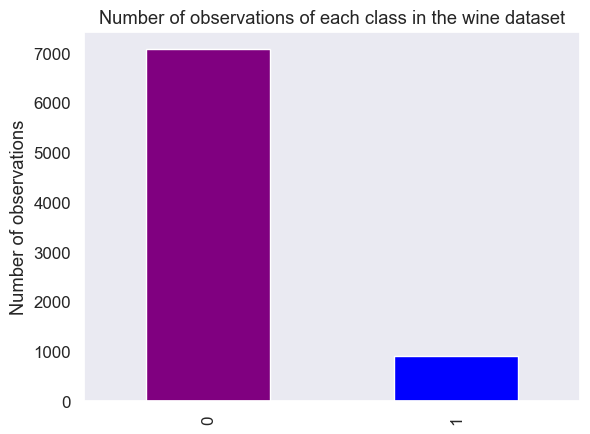

Unsafe: 7076, Safe: 910


In [396]:
y_class.value_counts().plot.bar(color=['purple', 'blue'], grid=False)
plt.ylabel('Number of observations')
plt.title('Number of observations of each class in the wine dataset')
plt.show()

print(
    f'Unsafe: {y_class.value_counts()[0]}, Safe: {y_class.value_counts()[1]}')


We have 7084 unsafe (class 0) and 912 safe (class 1) observations. We see that we have a heavy imbalance in our data, but since we care more about the characteristics of unsafe water, this might be alright.

- Split between training and test set **1 point**

_Note_: Use as parameters for splitting: `test_size=0.2`, `random_state=39`, `shuffle=True`


In [397]:

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=39, shuffle=True)


- Rescale your features using `StandardScaler` **1 point**


In [398]:

# Defining the standard scaler
standard_scaler = StandardScaler

# Using the previous created function to scale our data
X_train_class, X_test_class = get_scaler(
    X_train_class, X_test_class, standard_scaler)


### Question 8: Logistic Regression


- Build and train a logistic regression classifier, using as parameters `penalty='l2'`, `solver='lbfgs'`, `max_iter=1000` **1 point**


Just to clarify and note down what we are trying to do, we are using the Sigmoid function to predict our outcome : water safety.

This prediction can be defined by the following equation:
\begin{align*}
WaterSafety[0|1] = &\ w_0 + w_{i/0} \times[features] + \epsilon_i
\end{align*}


And using the Sigmoid function we bound our result between $[0,1]$:
$$S(WaterSafety) = \frac{1}{1 + e^{-WaterSafety}}$$


In [399]:

# Setting up logistic model
logistic_model = LogisticRegression(
    penalty='l2', solver='lbfgs', max_iter=1000)

# Fitting model
logistic_model.fit(X_train_class, y_train_class)


LogisticRegression(max_iter=1000)

- Compute the accuracy on the training and test set. Compare it to the default rate. **1 point**


In [400]:
# Function to create a pretty table

def get_pretty_table(names, rows):
    '''
    Function that return a prettytable, with the given name for titles and rows
    '''
    table = pt.PrettyTable()
    table.field_names = names

    for row in rows:
        table.add_row(row)

    # Add borders to the table
    table.hrules = pt.ALL
    table.header = True
    table.set_style(pt.SINGLE_BORDER)

    return table


In [401]:

# Accuracy on the test set
train_score = logistic_model.score(X_train_class, y_train_class)
test_score = logistic_model.score(X_test_class, y_test_class)

# Calculating default rate
quality_0 = water_df.loc[water_df[outcome_q7] == 0].shape[0]
quality_1 = water_df.loc[water_df[outcome_q7] == 1].shape[0]
default_rate = max(quality_0, quality_1)/water_df.shape[0]

# Using the get_pretty_table function to print in a nice way
print(get_pretty_table(['Logistic Regression Metrics', 'Values'],
                       [['Accuracy of Logistic regression classifier (training)', round(train_score, 3)],
                       ['Accuracy of Logistic regression classifier (test)', round(test_score, 3)],
                        ['Default rate', round(default_rate, 3)]
                        ]))


┌───────────────────────────────────────────────────────┬────────┐
│              Logistic Regression Metrics              │ Values │
├───────────────────────────────────────────────────────┼────────┤
│ Accuracy of Logistic regression classifier (training) │ 0.906  │
├───────────────────────────────────────────────────────┼────────┤
│   Accuracy of Logistic regression classifier (test)   │ 0.909  │
├───────────────────────────────────────────────────────┼────────┤
│                      Default rate                     │ 0.886  │
└───────────────────────────────────────────────────────┴────────┘


We can see that we are a little above the default rate. We perform a bit better than guessing unsafe all the time.

- Plot a heatmap of the confusion matrix. Class 1 is the positive class. How many false positive did we obtain? **1 point**


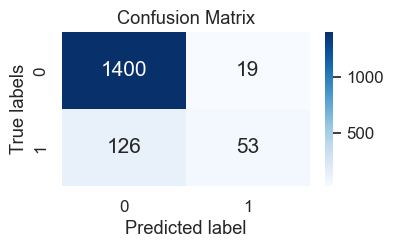

False positives: 19


In [402]:

# Predicting based on our trained logistic model
pred_class = logistic_model.predict(X_test_class)

# Use previous function to get heatmap
get_heatmap(confusion_matrix(y_test_class, pred_class), color='Blues', vmin=confusion_matrix(
    y_test_class, pred_class).min(), vmax=confusion_matrix(y_test_class, pred_class).max())
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test_class, pred_class).ravel()
print(f'False positives: {fp}')

We got 19 false positives.

- What is the precision, recall, and f1 score of class 1? Interpret the result. **1 point**


In [403]:
def get_prec_rec_f1(pred, y_test) -> tuple[float]:
    '''
    Function that returns the Precision, Recall and F1-score
    of the given predicted y-values values and  actual y values with the given model
    '''
    prec = precision_score(y_test, pred, zero_division=1)
    rec = recall_score(y_test, pred, zero_division=1)
    f1 = f1_score(y_test, pred, zero_division=1)
    return prec, rec, f1


def get_prec_rec_f1_df(X_train, X_test, y_train, y_test, model, column_name) -> pd.DataFrame:
    '''
    Function that returns a dataframe with the key performance features on training and test set
    '''
    # Predicting based on given model. Makes the function more dynamic
    pred = model.predict(X_test_class)

    # Accuracy on the test set
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # Getting performance
    prec, rec, f1 = get_prec_rec_f1(
        pred=pred, y_test=y_test)

    # Setting generic labels
    perf_tests_labels = ['Accuracy Training',
                         'Accuracy Test',
                         'Precision (Class 1)',
                         'Recall (Class 1)',
                         'F1-score (Class 1)']

    # Putting together dataframe
    df = pd.DataFrame([train_score, test_score, prec, rec, f1],
                      index=perf_tests_labels,
                      columns=[column_name])

    df = df.apply(lambda x: round(x, 3))
    return df

# Now we can use the function created to get all the performance metrics we want
perf_logistic_df = get_prec_rec_f1_df(X_train_class, X_test_class, y_train_class,y_test_class, logistic_model, 'Logistic Model Performance')
display(perf_logistic_df)


Logistic Model Performance
Accuracy Training                         0.906
Accuracy Test                             0.909
Precision (Class 1)                       0.736
Recall (Class 1)                          0.296
F1-score (Class 1)                        0.422

Reminder that;
$$Precision = \frac{TP}{TP+FP}, \quad Recall=\frac{TP}{TP+FN}, \quad and \quad F1 = 2 \frac{{Precision}\cdot{Recall}}{Precision+Recall}$$

With a precision at ~$70$% we predicted correctly when we predicted Class 1 ~70% of the time. Meaning the fraction of correct predicted positives over total positive prediction.  With a recall of ~$3%$, we are only correctly predicting the safe water ~$3$% of the time. Which means that out of the actual safe water, we predict safe water to be unsafe ~$97$% of the time. The $\text{F1 Score}$ is bounded in the interval $[0,1]$, where 1 means perfect precision and recall, which is low and indicates that the model is not performing well on the positive class. Which we can argue is ok, since it's unsafe water quality that is the most important thing to be good at. 

- Build and train a logistic regression classifier with cross-validation, using 5 folds **1 point**


In [404]:


logistic_model_cv = LogisticRegressionCV(penalty='l2', solver='lbfgs', cv=5, max_iter=1000)
logistic_model_cv.fit(X_train_class, y_train_class)



LogisticRegressionCV(cv=5, max_iter=1000)

- Plot a heatmap of the confusion matrix. Compute the accuracy on the training and test set; as well as the precision, recall, and f1 score of class 1. How do your metrics compare to your model without cross-validation? **1 point**

_Note_: You can, but not have to, create a function to calculate your evaluation metrics since we will perform the same operation later on.


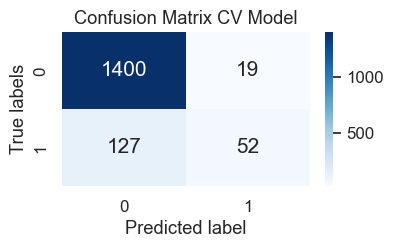

In [405]:
# Predicting based on our trained logistic CV model
pred_class_cv = logistic_model_cv.predict(X_test_class)

get_heatmap(confusion_matrix(y_test_class, pred_class_cv), color='Blues', vmin=confusion_matrix(
    y_test_class, pred_class_cv).min(), vmax=confusion_matrix(y_test_class, pred_class_cv).max())
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix CV Model')
plt.show()


In [406]:
# Again, we can re-use the function previously created
perf_cv_df = get_prec_rec_f1_df(X_train_class, X_test_class, y_train_class,
                                y_test_class, logistic_model_cv, 'Logistic CV Model Performance')

perf_comparison_df = perf_logistic_df.copy()
perf_comparison_df[perf_cv_df.columns[0]] = perf_cv_df
perf_comparison_df


Logistic Model Performance  Logistic CV Model Performance
Accuracy Training                         0.906                          0.906
Accuracy Test                             0.909                          0.909
Precision (Class 1)                       0.736                          0.732
Recall (Class 1)                          0.296                          0.291
F1-score (Class 1)                        0.422                          0.416

We can see that the CV model does not perform better than the normal logistic model. The same happens here. To not repeat myself by this could be due to the imbalanced nature of the dataset, where Class 1 has very few samples compared to Class 0. Which is exactly what we saw earlier. The training-set only includes $0.2 * 912 =  184,2$ "good water-quality" observations, making the model bad a predicting good water. Thus the model could be biased towards predicting Class 0 (unsafe) more often. Additionally, we can see from the correlation matrix heatmap that each individual feature does not have a huge correlation with the water safety. This could also impact our results. And as mentioned, the precision is more important than recall. But again, when it comes to drinking water it's better to be safe than sorry, even tough a more balanced dataset would make it easier to distinguish the two categories. Moreover, CV might not give us any better performance since we have a total of 8000 observations and the shuffle makes the sets we use to train our model representative, hence CV does not help. Even more, if the relationship is non-linear, logistic regression is not the right algorithm to solve this problem.

### Question 9: KNN classifier


- Build and train a KNN classifier with parameters `n_neighbors=7`, `p=2`, `weights='uniform'` **1 point**


In [407]:


# Copying train and test set from previous exercise
X_train_knn, X_test_knn, y_train_knn, y_test_knn = X_train_class, X_test_class, y_train_class, y_test_class

# Setting up the model, weights='uniform' is default
model_kNN = KNeighborsClassifier(n_neighbors=7, p=2)

# Fit our model
model_kNN.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=7)

- Plot a heatmap of the confusion matrix. Compute the accuracy on the training and test set; as well as the precision, recall, and f1 score of class 1. How do your metrics compare to your previous models? **1 point**


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



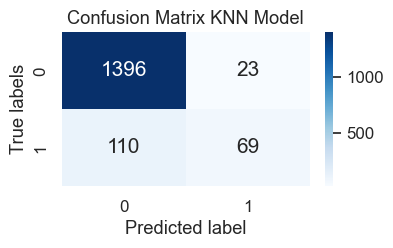

/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Logistic Model Performance  \
Accuracy Training                         0.906   
Accuracy Test                             0.909   
Precision (Class 1)                       0.736   
Recall (Class 1)                          0.296   
F1-score (Class 1)                        0.422   

                     Logistic CV Model Performance  KNN Model Performance  
Accuracy Training                            0.906                  0.930  
Accuracy Test                                0.909                  0.917  
Precision (Class 1)                          0.732                  0.750  
Recall (Class 1)                             0.291                  0.385  
F1-score (Class 1)                           0.416                  0.509

In [408]:
# Predicting based on our trained KNN model
pred_knn = model_kNN.predict(X_test_knn)

get_heatmap(confusion_matrix(y_test_knn, pred_knn), color='Blues', vmin=confusion_matrix(
    y_test_knn, pred_knn).min(), vmax=confusion_matrix(y_test_knn, pred_knn).max())
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix KNN Model')
plt.show()

# Getting performance metrics
perf_knn_df = get_prec_rec_f1_df(X_train_knn, X_test_knn, y_train_knn,y_test_knn, model_kNN, 'KNN Model Performance')

perf_knn_comparison_df = perf_comparison_df.copy()
perf_knn_comparison_df[perf_knn_df.columns[0]] = perf_knn_df
display(perf_knn_comparison_df)

Conclusion **before removing the negative values for ammonia**: We clearly see here that the KNN model performs poorly. This could be due to the fact that the KNN model is not sophisticated enough to capture the relationship between our features and the outcome. It might also bee that the KNN model handles the imbalanced data worse than our logistic models. So it could suggest that the decision boundary between the two classes is not highly dependent on the distance/proximity of the nearest neighbors in the feature-dimensional space...

**New conclusion** the KNN model performs a bit better than our Logistic Model. It was cool to see that removing 10 negative variables could have such a huge impact. Since we are using the scaler, our values goes from [-1,1] so it's not the fact that they where negative, but they where probably wrong. The nearest neighbor with euclidean distance was really punished by these wrong datapoints. The KNN algorithm could be better as well due to the fact that in handles non-linearity better than logistic regression.  (Previously i had (negative ammonia) a precision and recall around 0.4). Note to self: Check your data!


- Use `GridSearchCV` to explore different parameters for your model: `n_neighbors` between 1 and 11, `p` between 1 and 3, and `weights` either 'uniform' or 'distance' **1 point**


I assume that when it's written between:

- "Between 1 and 11" = [1,10] = [1,2,3,4,5,6,8,9,10]
- "Between 1 and 3" = [1,2] = [1,2]


In [418]:

# Defining ranges
neighbors = np.arange(1, 11)
p = np.arange(1, 3)

grid = {'n_neighbors': neighbors,
        'p': p,
        'weights': ['uniform', 'distance']   # weights
        }

# Defining and fit model with optimal
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)
knn_cv.fit(X_train_knn, y_train_knn)

# Printing results
print("Hyperparameters: ", knn_cv.best_params_)
print("Train Score: {:0.2f}".format(knn_cv.best_score_))
print("Test Score: {:0.2f}".format(knn_cv.score(X_test_knn, y_test_knn)))


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Hyperparameters:  {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Train Score: 0.91
Test Score: 0.92


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



- For your 'optimal' model, compute the accuracy on the training and test set; as well as the precision, recall, and f1 score of class 1. How do your metrics compare to your previous models? **1 point**


In [410]:
# Set up our model
model_kNN_optimal = KNeighborsClassifier(n_neighbors=9, p=2)

# Fit our model
model_kNN_optimal.fit(X_train_knn, y_train_knn)

perf_knn_df = get_prec_rec_f1_df(X_train_knn, X_test_knn, y_train_knn,
                                 y_test_knn, model_kNN_optimal, 'Optimal KNN Model Performance')


perf_knn_comparison_df[perf_knn_df.columns[0]] = perf_knn_df
display(perf_knn_comparison_df)


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Logistic Model Performance  \
Accuracy Training                         0.906   
Accuracy Test                             0.909   
Precision (Class 1)                       0.736   
Recall (Class 1)                          0.296   
F1-score (Class 1)                        0.422   

                     Logistic CV Model Performance  KNN Model Performance  \
Accuracy Training                            0.906                  0.930   
Accuracy Test                                0.909                  0.917   
Precision (Class 1)                          0.732                  0.750   
Recall (Class 1)                             0.291                  0.385   
F1-score (Class 1)                           0.416                  0.509   

                     Optimal KNN Model Performance  
Accuracy Training                            0.926  
Accuracy Test                                0.916  
Precision (Class 1)                          0.778  
Recall (Class 1)                             0.352  
F1-score (Class 1)                           0.485

We can see that the model does not really change. Maybe a slight improvement in Precision. Still performing better than the logistic models.

### Question 10: Decision Trees


- Build and train a Decision Tree with parameters `criterion = 'gini'`, `max_depth = 3` **1 point**


In [421]:
from sklearn.tree import DecisionTreeClassifier


# Now with decision tree we don't need the scaled data, DT can even handle categorical data
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_class, y_class, test_size=0.2, random_state=39, shuffle=True)

# Copying train and test set from previous exercise to keep things clean
X_train_tree, X_test_tree, y_train_tree, y_test_tree = X_train_class, X_test_class, y_train_class, y_test_class



# Create model
model_tree = DecisionTreeClassifier(criterion='gini', max_depth=3)

# Fit model
model_tree.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=3)

I tested the three with both scaled and not scaled data, the latter had 1% better recall for the optimal solution. Otherwise they where almost identical. 

- Plot a heatmap of the confusion matrix. Compute the accuracy on the training and test set; as well as the precision, recall, and f1 score of class 1. How do your metrics compare to your previous models? **1 point**


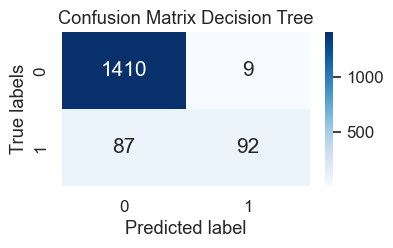

Logistic Model Performance  \
Accuracy Training                         0.906   
Accuracy Test                             0.909   
Precision (Class 1)                       0.736   
Recall (Class 1)                          0.296   
F1-score (Class 1)                        0.422   

                     Logistic CV Model Performance  KNN Model Performance  \
Accuracy Training                            0.906                  0.930   
Accuracy Test                                0.909                  0.917   
Precision (Class 1)                          0.732                  0.750   
Recall (Class 1)                             0.291                  0.385   
F1-score (Class 1)                           0.416                  0.509   

                     Optimal KNN Model Performance  Decision Tree Performance  
Accuracy Training                            0.926                      0.941  
Accuracy Test                                0.916                      0.940  
Precision (Class 1)                          0.778                      0.911  
Recall (Class 1)                             0.352                      0.514  
F1-score (Class 1)                           0.485                      0.657

In [422]:

# Predicting based on our trained Decision Tree
pred_tree = model_tree.predict(X_test_tree)

get_heatmap(confusion_matrix(y_test_knn, pred_tree), color='Blues', vmin=confusion_matrix(
    y_test_tree, pred_tree).min(), vmax=confusion_matrix(y_test_tree, pred_tree).max())
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix Decision Tree')
plt.show()

# Getting performance metrics
perf_tree_df = get_prec_rec_f1_df(
    X_train_tree, X_test_tree, y_train_tree, y_test_tree, model_tree, 'Decision Tree Performance')

all_comparison = perf_knn_comparison_df.copy()

all_comparison[perf_tree_df.columns[0]] = perf_tree_df
display(all_comparison)


The decision tree performs even better than the previous models! First model with a precision over 90%. We have a quite large set of features, which could favour the decision tree over KNN and Logistic regression. The Decision tree can capture nonlinear relationships between the features and the target variable. On the other side, logistic regression assumes that this relationship is linear.

- Visualize your Decision Tree **1 point**


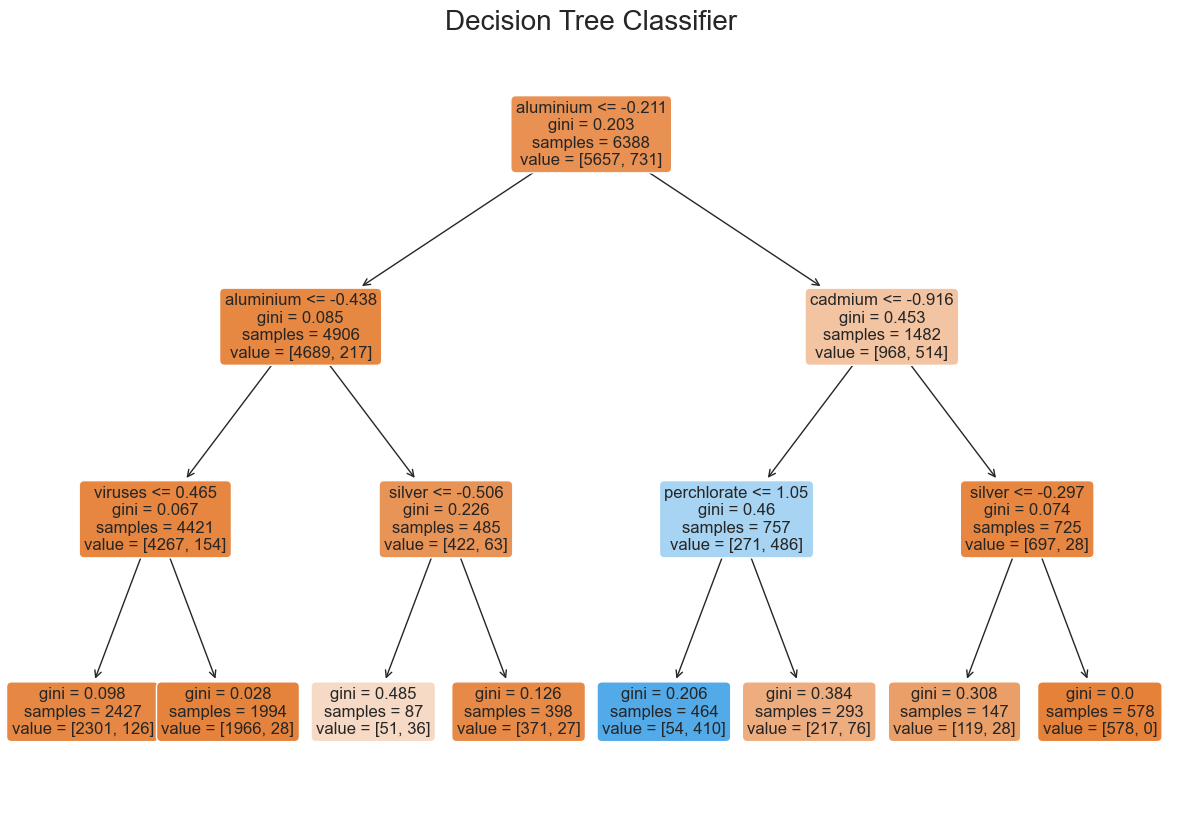

In [423]:
# Creating figure
plt.figure(figsize=(15, 10))
plot_tree(model_tree, filled=True,
          feature_names=features_classification, fontsize=12, rounded=True)

# Setting some labels
plt.title("Decision Tree Classifier", fontsize=20)
plt.xlabel("Features", fontsize=16)
plt.ylabel("Target Variable", fontsize=16)
plt.show()


- Use `GridSearchCV` to explore different parameters for your model: `criterion` either 'gini' or 'entropy' and `max_depth` between 1 and 7 **1 point**


In [424]:
# Define parameters to test
grid_tree = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(1, 8)}

# Define and fit model
tree_class = DecisionTreeClassifier()
tree_class_cv = GridSearchCV(tree_class, grid_tree, cv=5)
tree_class_cv.fit(X_train_tree, y_train_tree)

# Print results
print("Best model:", tree_class_cv.best_estimator_)
print("Train Score: {:0.2f}".format(tree_class_cv.best_score_))
print("Test Score: {:0.2f}".format(tree_class_cv.score(X_test_tree, y_test_tree)))


Best model: DecisionTreeClassifier(criterion='entropy', max_depth=7)
Train Score: 0.96
Test Score: 0.96


- For your 'optimal' model, compute the accuracy on the training and test set; as well as the precision, recall, and f1 score of class 1. How do your metrics compare to your previous models? **1 point**


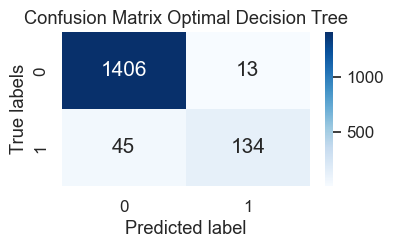


True Negatives: 1406        
False Negatives: 45        
False Positives: 13        True Positives: 134


Logistic Model Performance  \
Accuracy Training                         0.906   
Accuracy Test                             0.909   
Precision (Class 1)                       0.736   
Recall (Class 1)                          0.296   
F1-score (Class 1)                        0.422   

                     Logistic CV Model Performance  KNN Model Performance  \
Accuracy Training                            0.906                  0.930   
Accuracy Test                                0.909                  0.917   
Precision (Class 1)                          0.732                  0.750   
Recall (Class 1)                             0.291                  0.385   
F1-score (Class 1)                           0.416                  0.509   

                     Optimal KNN Model Performance  Decision Tree Performance  \
Accuracy Training                            0.926                      0.941   
Accuracy Test                                0.916                      0.940   
Precision (Class 1)                          0.778                      0.911   
Recall (Class 1)                             0.352                      0.514   
F1-score (Class 1)                           0.485                      0.657   

                     Optimal Decision Tree Performance  
Accuracy Training                                0.977  
Accuracy Test                                    0.964  
Precision (Class 1)                              0.912  
Recall (Class 1)                                 0.749  
F1-score (Class 1)                               0.822

In [425]:


model_tree_optimal = DecisionTreeClassifier(criterion='entropy', max_depth=7)

# Fit model
model_tree_optimal.fit(X_train_tree, y_train_tree)

# Predicting based on our trained Decision Tree
pred_tree_optimal = model_tree_optimal.predict(X_test_tree)

get_heatmap(confusion_matrix(y_test_knn, pred_tree_optimal), color='Blues', vmin=confusion_matrix(
    y_test_tree, pred_tree).min(), vmax=confusion_matrix(y_test_tree, pred_tree_optimal).max())
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix Optimal Decision Tree')
plt.show()

# Getting performance metrics
perf_tree_optimal_df = get_prec_rec_f1_df(
    X_train_tree, X_test_tree, y_train_tree, y_test_tree, model_tree_optimal, 'Optimal Decision Tree Performance')


tn, fp, fn, tp = confusion_matrix(y_test_knn, pred_tree_optimal).ravel()

print(f'\nTrue Negatives: {tn}\
        \nFalse Negatives: {fn}\
        \nFalse Positives: {fp}\
        True Positives: {tp}')

all_comparison[perf_tree_optimal_df.columns[0]] = perf_tree_optimal_df
display(all_comparison)


Best accuracy on training set so far, and almost the same precision as the previous decision tree. But not the lowest false positive which might be what we really care about in this case which is related to how many times have we told people that the water is safe, but it's actually not. Overall the decisions tree performed well! Well suited for a lot of features with a complex relation to the outcome variable.

Congrats, you are done with the assignment!


In [416]:
%load_ext watermark
%watermark -v -p pandas,numpy,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.33.0

pandas : 1.4.3
numpy  : 1.21.5
sklearn: 1.1.1

